# Librairies et réglages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import joblib

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import os

# Preprocessing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Modélisation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

# Over-sampling / Under-sampling
import imblearn
from imblearn.under_sampling  import RandomUnderSampler
from collections import Counter

# Ne pas afficher les warnings
import warnings
warnings.filterwarnings("ignore")

# Options graphiques
sns.set(rc={'figure.figsize':(16,16)})
pd.options.display.max_columns = 150
sns.set_style('darkgrid')
sns.set_context("notebook", 
                font_scale=1.5, 
                rc={"lines.linewidth": 2.5})
plt.style.use('ggplot')

# Fonctions

In [2]:
# Fonction permettant de visualiser la quantité de données manquantes

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [3]:
# Fonction permettant de visualiser la répartition pour une catégorie selon la target (0 ou 1)

def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Nombre de contrats': temp.values})

    # Calcule le pourcentage que la target=1 pour la catégorie en question
    cat_perc = app_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Nombre de contrats",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Pourcentage de target avec valeur 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

In [4]:
# Fonction permettant de visualiser la distribution d'une feature
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution de %s" % feature)
    sns.distplot(app_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()   

In [5]:
# Fonction permettant de visualiser la distribution de plusieurs features
def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = app_train.loc[app_train['TARGET'] != 0]
    t0 = app_train.loc[app_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [6]:
# Fonction permettant d'afficher l'éboulis des valeurs propres

def display_scree_plot(acp):

    scree = acp.explained_variance_ratio_*100
    plt.figure(figsize=(8, 8))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Éboulis des valeurs propres")
    plt.show(block=False)

In [7]:
# Fonction permettant de réaliser une ACP

def application_pca(df, taux=0.9):
    
    # n_comp = 40
    pca = PCA(taux)

    X_pca = pd.DataFrame(pca.fit_transform(df))

    # Appel de la fonction qui trace la courbe des éboulis des valeurs propres
    display_scree_plot(pca)

    return X_pca

In [8]:
def preprocesseur(df_train, df_test, imputername, scalername):
    
    # Supprime la Target du training set
    if "TARGET" in df_train:
        train = df_train.drop(columns = ["TARGET"])
    else:
        train = df_train.copy()
        
    # Nom des features
    features = list(train.columns)

    # Imputation médiane des valeurs manquantes
    imputer = SimpleImputer(strategy = 'median')

    # Scaling de chaque feature
    scaler = MinMaxScaler(feature_range = (0, 1))

    # Remplace les colonnes booléennes par des valeurs numériques
    train["DAYS_EMPLOYED_ANOM"] = train["DAYS_EMPLOYED_ANOM"].astype("int")

    # Fit sur le training set
    imputer.fit(train)
    filename = imputername + ".pkl"
    joblib.dump(imputer, filename)

    # Transformation du training et testing set
    train = imputer.transform(train)
    test = imputer.transform(df_test)

    # Scaler
    scaler.fit(train)
    filename = scalername + ".pkl"
    joblib.dump(scaler, filename)
    train = scaler.transform(train)
    test = scaler.transform(test)
    
    return train, test

In [9]:
def echantillonage(df_X, df_y):

    X = df_X.copy()
    y = df_y.copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    return X_train, X_test, y_train, y_test

In [10]:
def log_reg(df_X_train, df_y_train, df_y_test, df_X_test):
    
    # Création du modèle avec les paramètres spécifiés
    log_reg = LogisticRegression(C = 0.0001)

    # Entraînement sur le training data
    log_reg.fit(df_X_train, df_y_train)
    
    y_pred = log_reg.predict(df_X_test)

    accuracy = accuracy_score(df_y_test, y_pred)
    
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    # Création des prédictions
    # Sélection de la deuxième colonne
    log_reg_pred = log_reg.predict_proba(df_X_test)[:, 1]
    
    return log_reg_pred

In [11]:
def save_results(df_res, df_pred, new_col, df_index):

    df_pred_lr = pd.DataFrame(df_pred, columns=[new_col], index=df_index.index)

    df_res = pd.concat([df_res, df_pred_lr], sort=False, axis=1)
    
    return df_res

In [12]:
def transform_treshold(df, tresh):
    
    new_df = (df >= tresh).astype("int")
    
    return new_df

In [13]:
# Fonction permettant d'afficher une matrice de confusion

def aff_confusion_matrix(df_true, df_pred):

    conf_mat = confusion_matrix(df_true, df_pred)

    print('Confusion matrix:\n', conf_mat)

    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

In [14]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

# Chargement des données

In [15]:
app_train = pd.read_csv(r"C:\Users\tothm\PycharmProjects\Projet 7\datasets\application_train.csv")
app_test = pd.read_csv(r"C:\Users\tothm\PycharmProjects\Projet 7\datasets\application_test.csv")
bureau = pd.read_csv(r"C:\Users\tothm\PycharmProjects\Projet 7\datasets\bureau.csv")
bureau_balance = pd.read_csv(r"C:\Users\tothm\PycharmProjects\Projet 7\datasets\bureau_balance.csv")
credit_card_balance = pd.read_csv(r"C:\Users\tothm\PycharmProjects\Projet 7\datasets\credit_card_balance.csv")
installments_payments = pd.read_csv(r"C:\Users\tothm\PycharmProjects\Projet 7\datasets\installments_payments.csv")
previous_application = pd.read_csv(r"C:\Users\tothm\PycharmProjects\Projet 7\datasets\previous_application.csv")
POS_CASH_balance = pd.read_csv(r"C:\Users\tothm\PycharmProjects\Projet 7\datasets\POS_CASH_balance.csv")

# Analyse Exploratoire

## Types des colonnes

In [16]:
# Colonnes de chaque type
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [17]:
# Catégories uniques des colonnes de type object
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Données présentes / manquantes

### app_train

In [18]:
print('app_train data shape: ', app_train.shape)
app_train.head()

app_train data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [19]:
missing_data(app_train).head(10)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


### app_test

In [20]:
print('app_test data shape: ', app_test.shape)
app_test.head()

app_test data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [21]:
missing_data(app_test).head(10)

,Total,Percent
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
NONLIVINGAPARTMENTS_AVG,33347,68.412523
NONLIVINGAPARTMENTS_MODE,33347,68.412523
NONLIVINGAPARTMENTS_MEDI,33347,68.412523
FONDKAPREMONT_MODE,32797,67.284179
LIVINGAPARTMENTS_AVG,32780,67.249302
LIVINGAPARTMENTS_MODE,32780,67.249302
LIVINGAPARTMENTS_MEDI,32780,67.249302


### bureau

In [22]:
print('bureau data shape: ', bureau.shape)
bureau.head()

bureau data shape:  (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [23]:
missing_data(bureau).head(10)

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
CREDIT_ACTIVE,0,0.000000
CREDIT_CURRENCY,0,0.000000
DAYS_CREDIT,0,0.000000


### bureau_balance

In [24]:
print('bureau_balance data shape: ', bureau_balance.shape)
bureau_balance.head()

bureau_balance data shape:  (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [25]:
missing_data(bureau_balance).head(10)

,Total,Percent
SK_ID_BUREAU,0,0.0
MONTHS_BALANCE,0,0.0
STATUS,0,0.0


### credit_card_balance

In [26]:
print('credit_card_balance data shape: ', credit_card_balance.shape)
credit_card_balance.head()

credit_card_balance data shape:  (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [27]:
missing_data(credit_card_balance).head(10)

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208
SK_ID_PREV,0,0.000000


### installments_payments

In [28]:
print('installments_payments data shape: ', installments_payments.shape)
installments_payments.head()

installments_payments data shape:  (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [29]:
missing_data(installments_payments).head(10)

,Total,Percent
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_PAYMENT,2905,0.021352
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
NUM_INSTALMENT_VERSION,0,0.000000
NUM_INSTALMENT_NUMBER,0,0.000000
DAYS_INSTALMENT,0,0.000000
AMT_INSTALMENT,0,0.000000


### previous_application

In [30]:
print('previous_application data shape: ', previous_application.shape)
previous_application.head()

previous_application data shape:  (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
missing_data(previous_application).head(10)

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_TERMINATION,673065,40.298129
DAYS_LAST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129


### POS_CASH_balance

In [32]:
print('POS_CASH_balance data shape: ', POS_CASH_balance.shape)
POS_CASH_balance.head()

POS_CASH_balance data shape:  (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [33]:
missing_data(POS_CASH_balance).head(10)

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
NAME_CONTRACT_STATUS,0,0.000000
SK_DPD,0,0.000000
SK_DPD_DEF,0,0.000000


## Visualisation graphique

### Equilibre des classes

0 représente un prêt remboursé, 1 représente un prêt non remboursé.

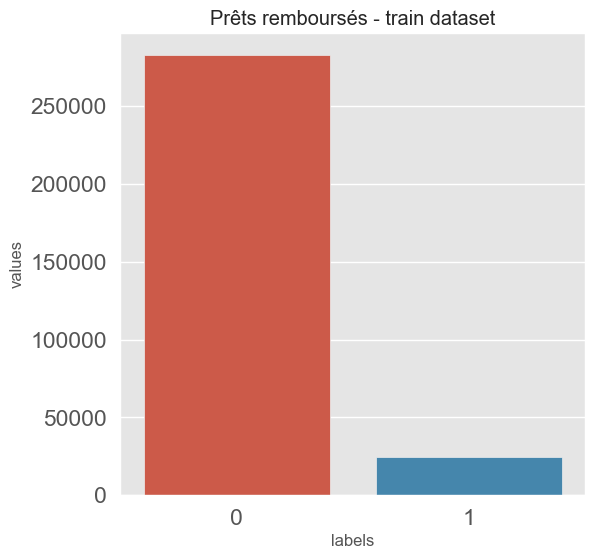

In [34]:
temp = app_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Prêts remboursés - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

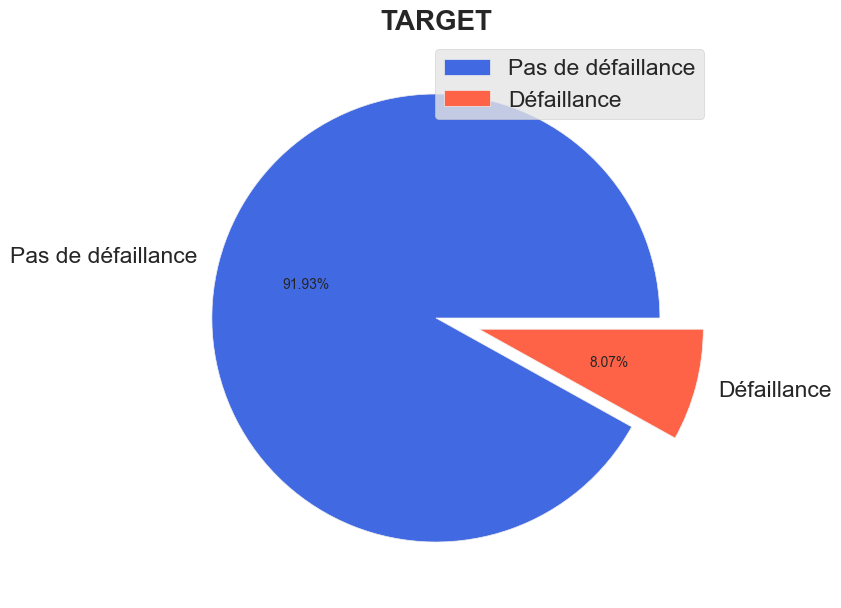

In [35]:
plt.subplot(2, 2, 2)
plt.title('TARGET', size=20, weight='bold')
plt.pie(app_train['TARGET'].value_counts(), 
        labels=['Pas de défaillance', 'Défaillance'],
        colors = ['royalblue', 'tomato'], 
        explode = [0, 0.2],
        autopct = lambda x: str(round(x, 2)) + '%')
plt.legend()

On peut remarquer qu'il y a beaucoup plus de prêts remboursés que de prêts non-remboursés.

### Type de contrat

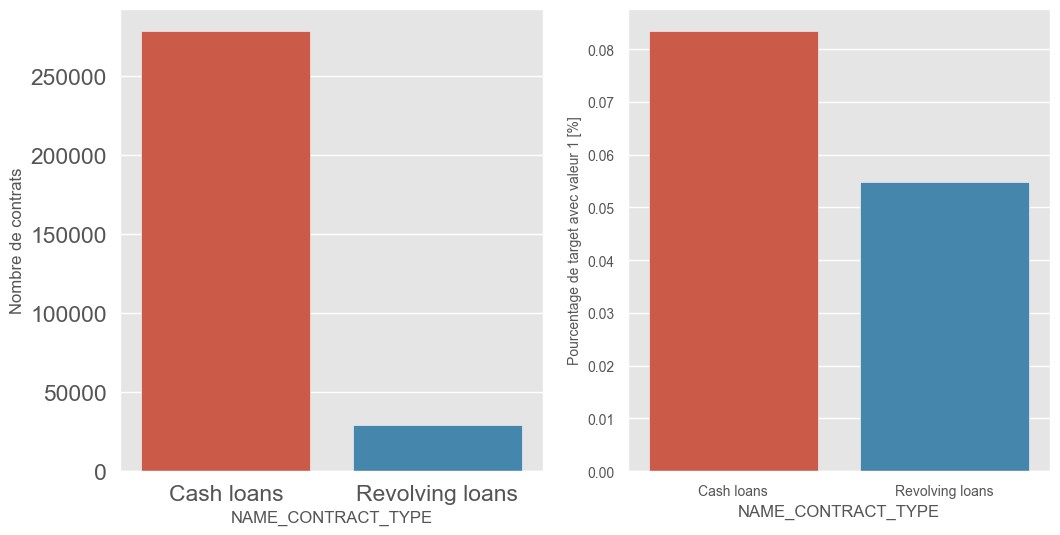

In [36]:
plot_stats('NAME_CONTRACT_TYPE')

Les contrats de type "revolving loans" représentent environ 10% du nombre total de prêts.

Si l'on compare avec leur fréquence, un plus grand nombre de prêts "revolving loans" semblent ne pas être remboursés.

### Sexe du client

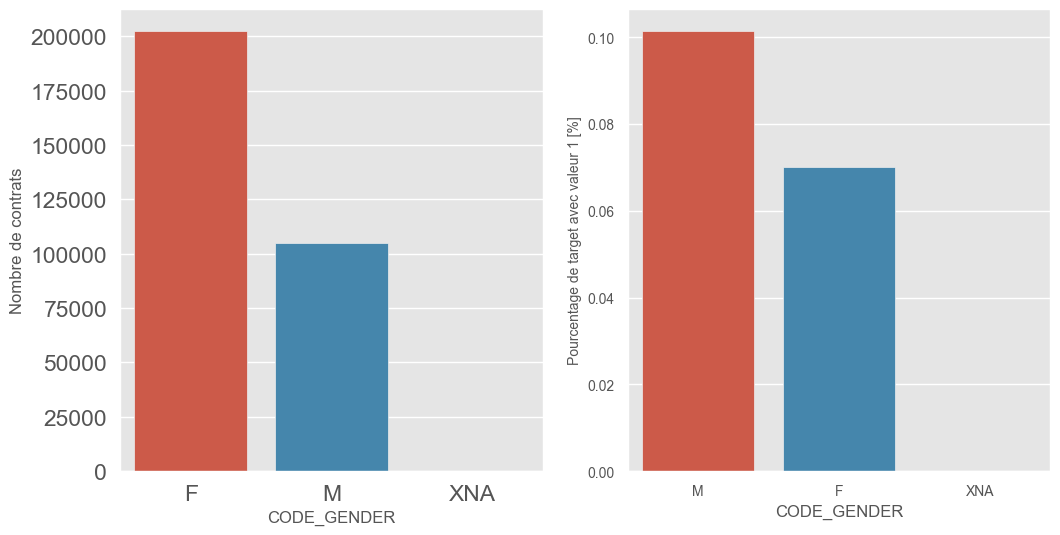

In [37]:
plot_stats('CODE_GENDER')

Il y a beaucoup plus de clients qui sont des femmes. De plus, les hommes semblent être plus encluns à ne pas rembourser leurs prêts comparés aux femmes.

### Propriétaires de voitures ou de biens immobiliers

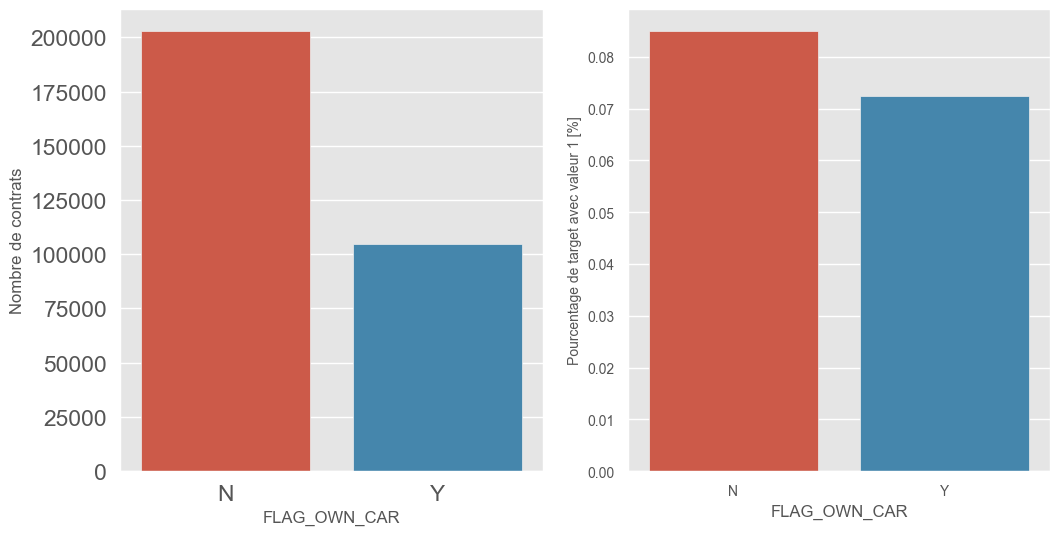

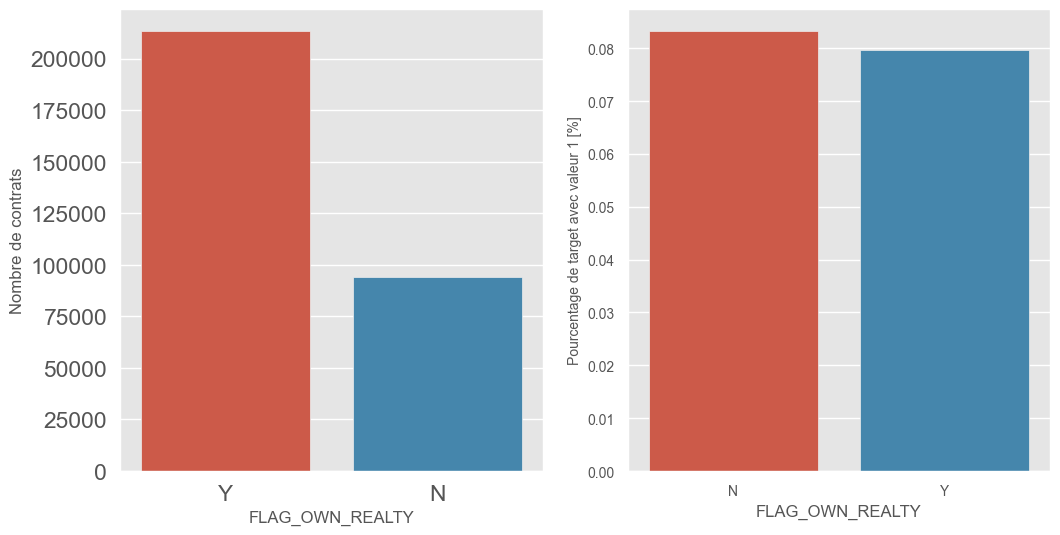

In [38]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

Les clients qui ne possèdent pas de voiture sont environ le double de ceux qui en possèdent une; posséder une voiture semble légèrement diminuer le risque de non-remboursement.

Inversement, les clients qui possèdent un bien immobilier sont plus du double de ceux qui n'en possèdent pas; la possession de bien immobilier ne semble pas beaucoup influencer la probabilité de non-remboursement.

### Status familial

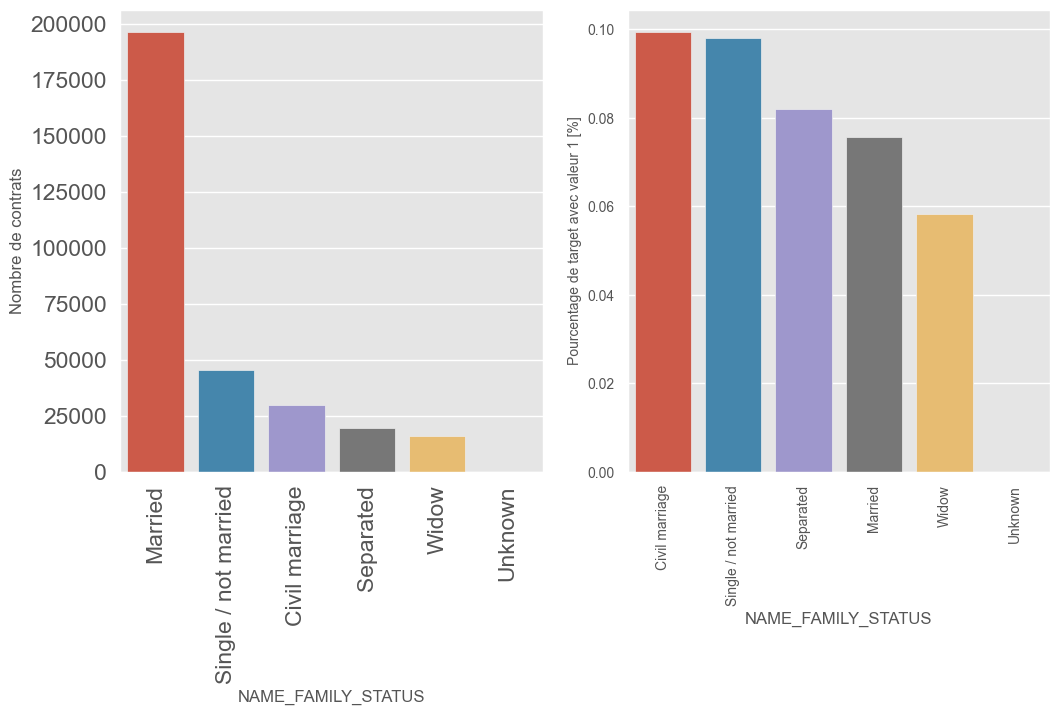

In [39]:
plot_stats('NAME_FAMILY_STATUS',True, True)

Les clients marriés représentent la très grande majorité des contrats. La catégorie la plus à risque de ne pas rembourser est "civil marriage" et la moins à risque est "widow".

### Nombre d'enfants

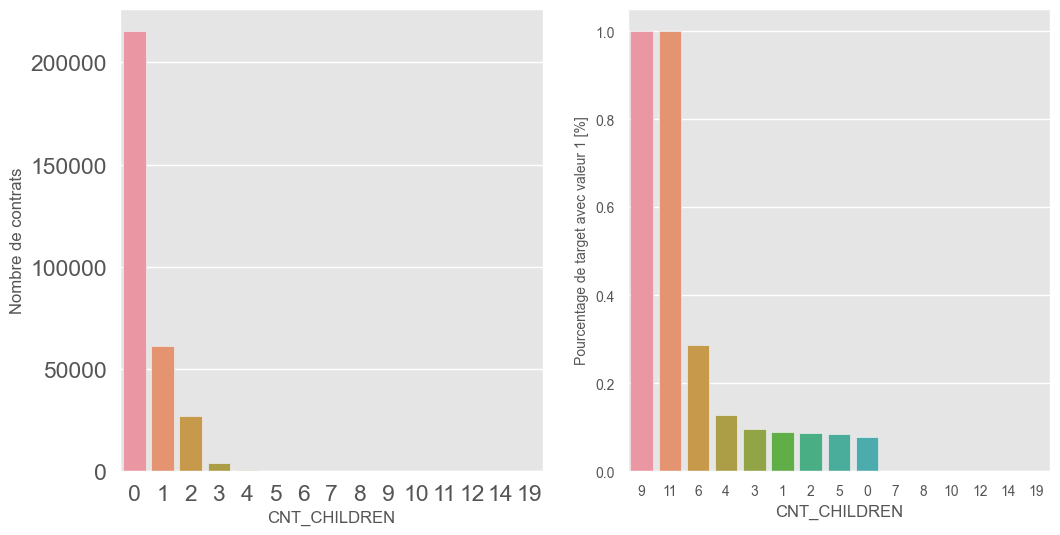

In [40]:
plot_stats('CNT_CHILDREN')

La plupart des clients n'ont pas d'enfants. Les clients avec 4 ou 6 enfants sont au dessus de la moyenne en termes de pourcentage de prêts non-remboursés, tandis que les clients avec 9 ou 11 enfants ont un pourcentage de non-remboursement de 100%. 

### Membres de la famille

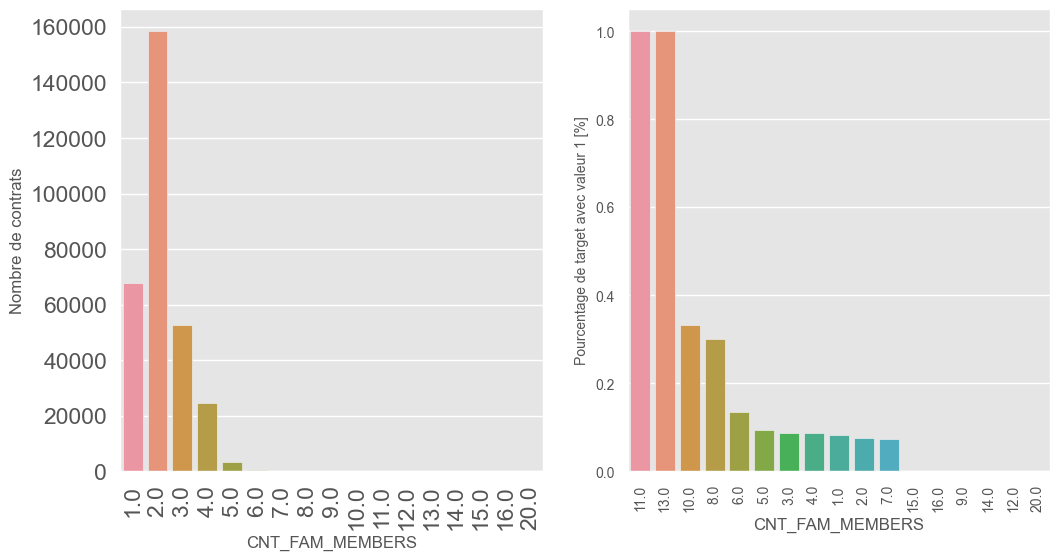

In [41]:
plot_stats('CNT_FAM_MEMBERS',True)

Les clients avec une famille de deux membres sont les plus nombreux, suivis de 1 (personne seule), 3 et 4.
Les clients avec une famille de 8 ou 10 membres sont à environ 30% de risque de non-remboursement.
Les clients avec une famille de 11 et 13 membres ont un taux de non-remboursement de 100%.

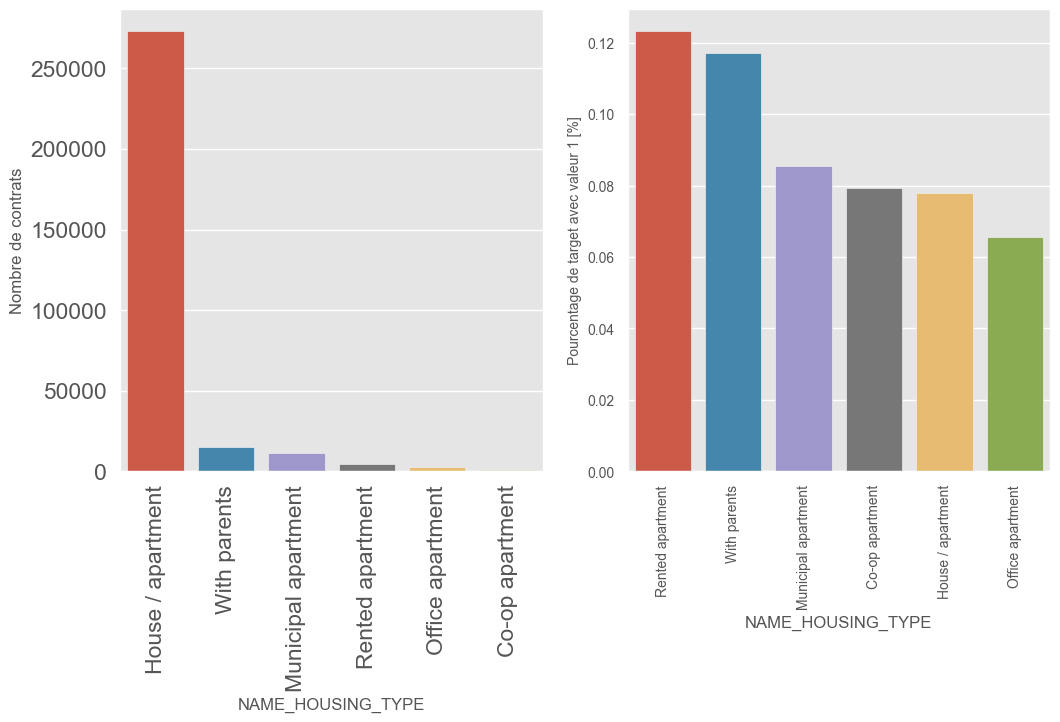

In [42]:
plot_stats('NAME_HOUSING_TYPE',True)

### Jours employés

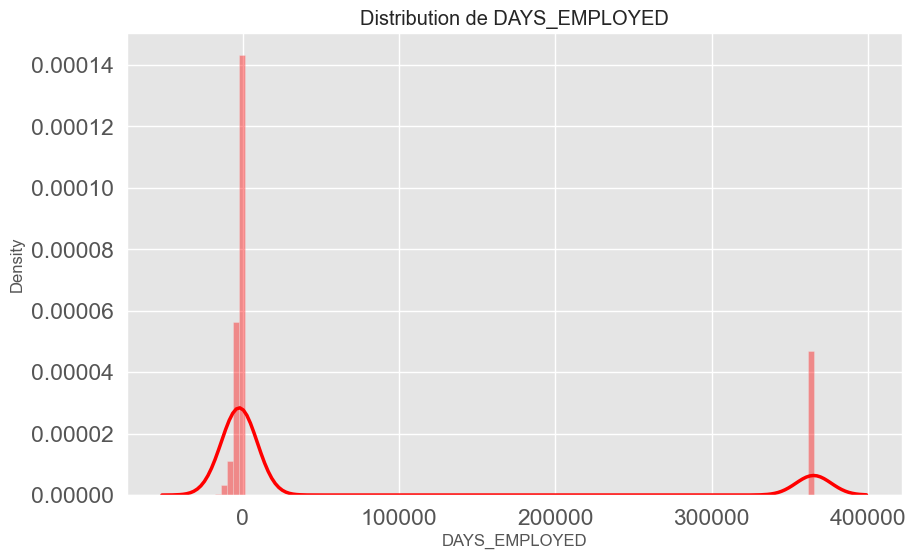

In [43]:
plot_distribution('DAYS_EMPLOYED','red')

On remarque une anomalie, en effet il est difficile d'imaginer que certaines personnes aient été employées plus de 300 000 jours
 (presque 1000 ans).

### Gestion de l'anomalie

In [44]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
print('%d clients sont concernés par cette anomalie.' % len(anom))

55374 clients sont concernés par cette anomalie.


On remplace ces erreurs par une valeur manquante.

In [45]:
# Création d'une colonne pour repérer les anomalies
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Remplaçage des erreurs par une valeur NaN
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

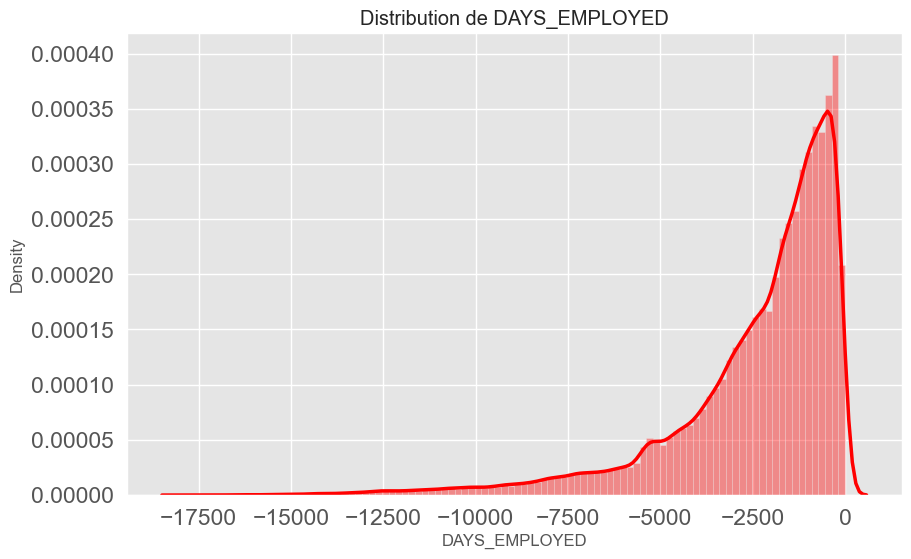

In [46]:
plot_distribution('DAYS_EMPLOYED','red')

Important : les modifications faites au training set doivent aussi être appliquées au testing set.

In [47]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('Il y a %d anomalies dans le training set (sur les %d entrées totales).' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

Il y a 9274 anomalies dans le training set (sur les 48744 entrées totales).


## Corrélations

In [48]:
# On utilise df.corr() pour trouver les features les plus corrélées à TARGET
correlations = app_train.corr()['TARGET'].sort_values()

print('Corrélations les plus positives:\n', correlations.tail(15))
print('\nCorrélations les plus négatives:\n', correlations.head(15))

Corrélations les plus positives:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Corrélations les plus négatives:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              

### Âge des clients

In [49]:
# Corrélation entre l'âge et la TARGET
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982692

Une corrélation négative indique que les clients plus âgés sont moins à risque de ne pas rembourser les prêts.

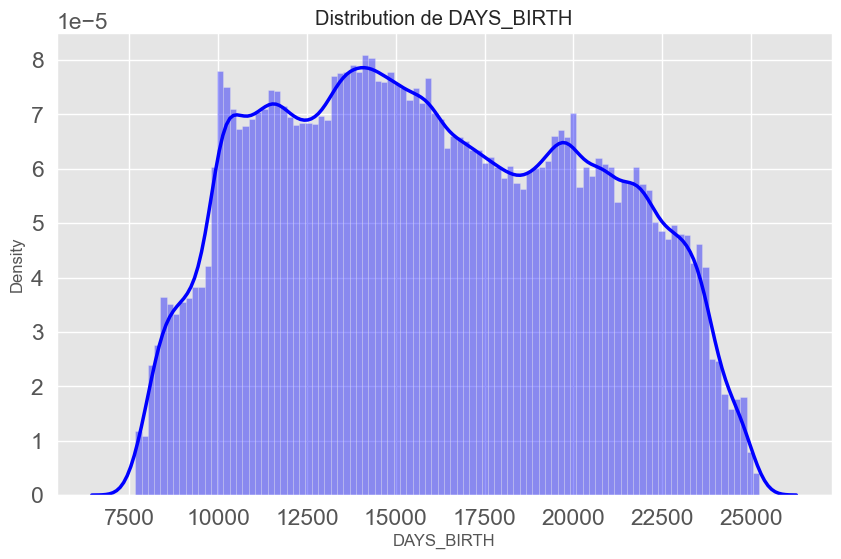

In [50]:
plot_distribution('DAYS_BIRTH','blue')

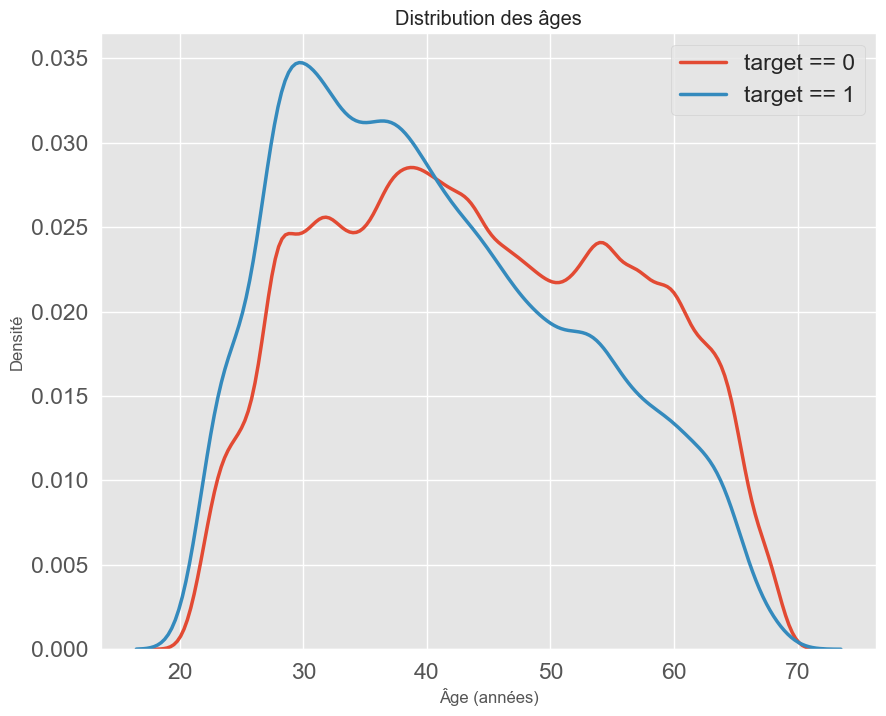

In [51]:
plt.figure(figsize = (10, 8))

# Graphique KDE des prêts remboursés à temps
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# Graphique KDE des prêts non-remboursés à temps
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Légende
plt.xlabel('Âge (années)'); plt.ylabel('Densité'); plt.title('Distribution des âges'); plt.legend();

In [52]:
# Âge sur un dataframe séparé
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Découpage des données
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [53]:
# Regroupage et calcul de la moyenne
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


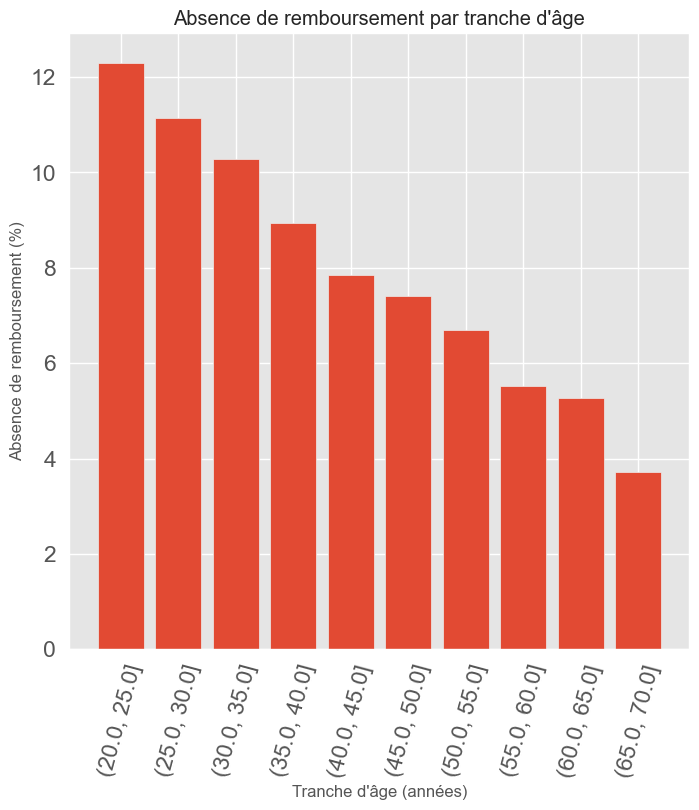

In [54]:
plt.figure(figsize = (8, 8))

# Affichage du graphique des moyennes par tranche d'âge
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Légende
plt.xticks(rotation = 75); plt.xlabel("Tranche d'âge (années)"); plt.ylabel("Absence de remboursement (%)")
plt.title("Absence de remboursement par tranche d'âge");

### Sources extérieures

In [55]:
# Extraction des variables EXT_SOURCE et affichage des correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


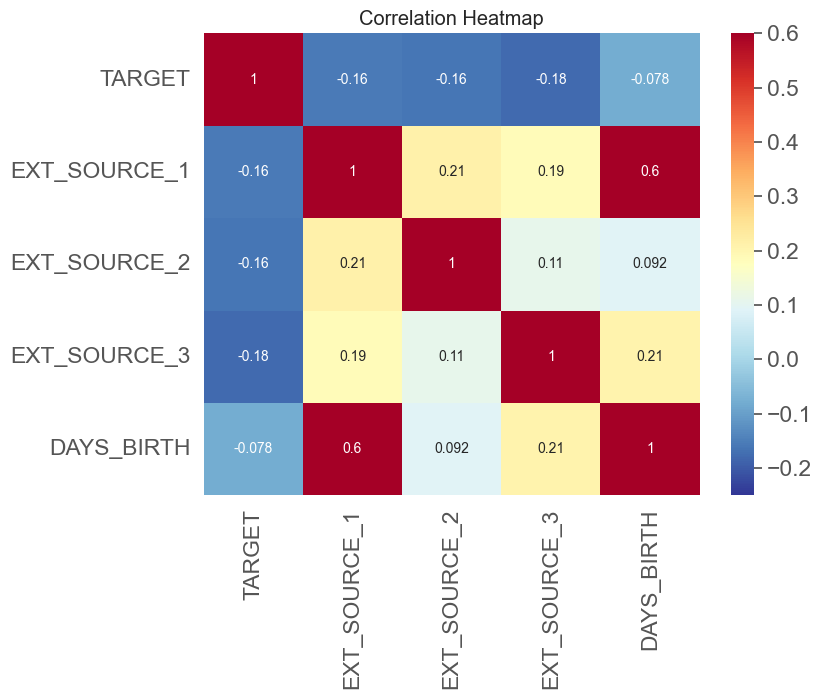

In [56]:
plt.figure(figsize = (8, 6))

# Heatmap des correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

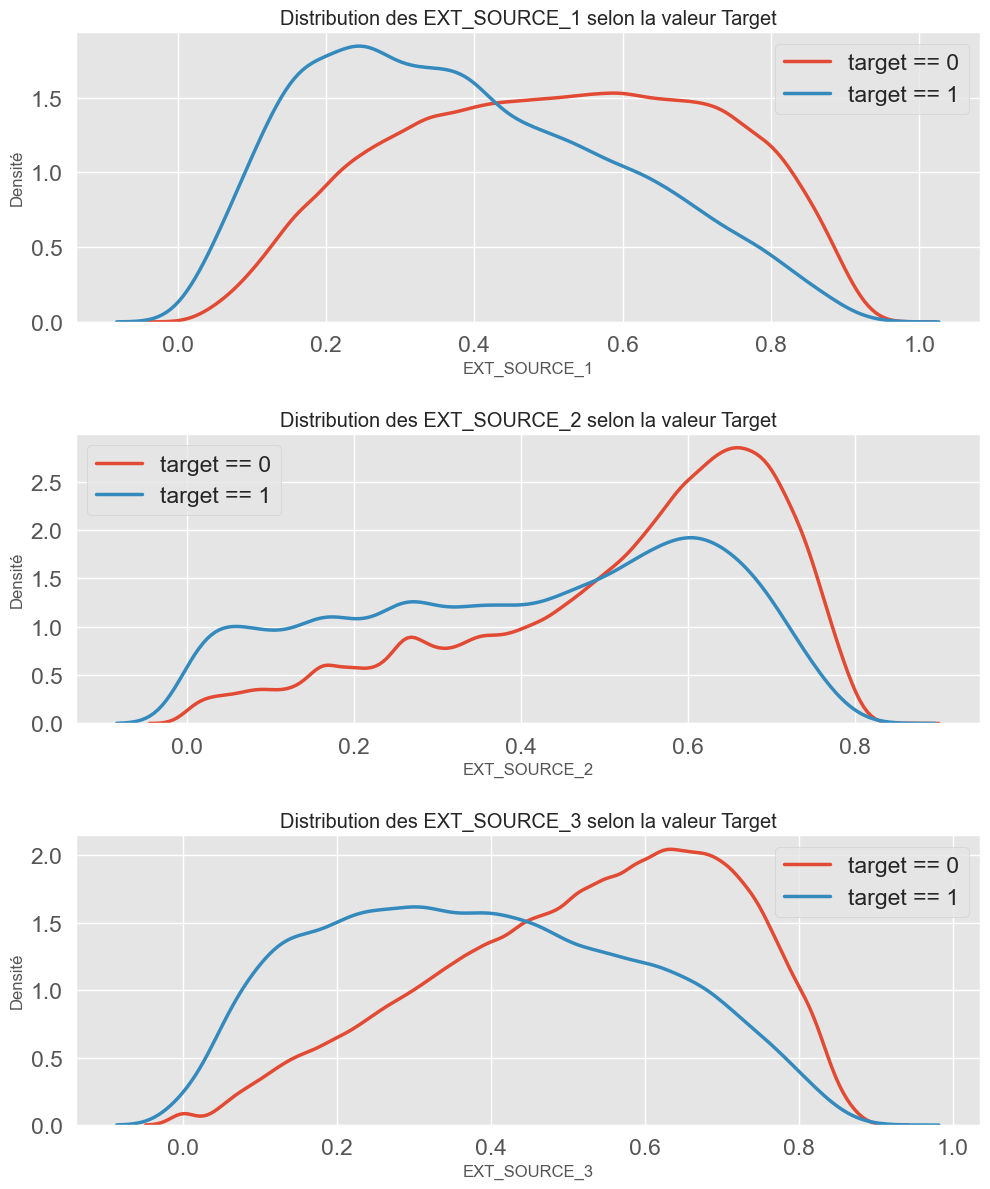

In [57]:
plt.figure(figsize = (10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # Subplot pour chaque source
    plt.subplot(3, 1, i + 1)
    # Graphique (prêts remboursés)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # Graphique (prêts non-remboursés)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Légende
    plt.title('Distribution des %s selon la valeur Target' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densité')
    plt.legend();
    
plt.tight_layout(h_pad = 2.5)

# Feature Engineering

## Encodage des variables qualitatives

In [58]:
# Création d'un objet LabelEncoder
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        # Si 2 ou moins de catégories uniques
        if len(list(app_train[col].unique())) <= 2:
            # Entraînement sur le training data
            le.fit(app_train[col])
            filename = 'encoder_' + str(le_count) + '.pkl'
            joblib.dump(le, filename)
            # Transformation des training et testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Compteur des colonnes encodées
            le_count += 1
            
print('%d colonnes ont été encodées.' % le_count)

3 colonnes ont été encodées.


In [59]:
# Encodage one-hot des variables qualitatives
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Dimension des training features: ', app_train.shape)
print('Dimension des testing features: ', app_test.shape)

Dimension des training features:  (307511, 244)
Dimension des testing features:  (48744, 240)


In [60]:
train_labels = app_train['TARGET']

# Alignement des données de training et testing, en ne gardant que les colonnes déjà présentes dans les deux dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Rajout de la Target
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 240)


## Features liées à la problématique métier

Pour améliorer nos prédictions, on rajoute 4 features liées aux prêts des clients :

CREDIT_INCOME_PERCENT: Pourcentage du montant de crédit par rapport aux revenus du client
ANNUITY_INCOME_PERCENT: Pourcentage du montant du prêt annuel par rapport aux revenus du client
CREDIT_TERM: Durée du paiement en mois
DAYS_EMPLOYED_PERCENT: Pourcentage des jours employés par rapport à l'âge du client

In [61]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [62]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

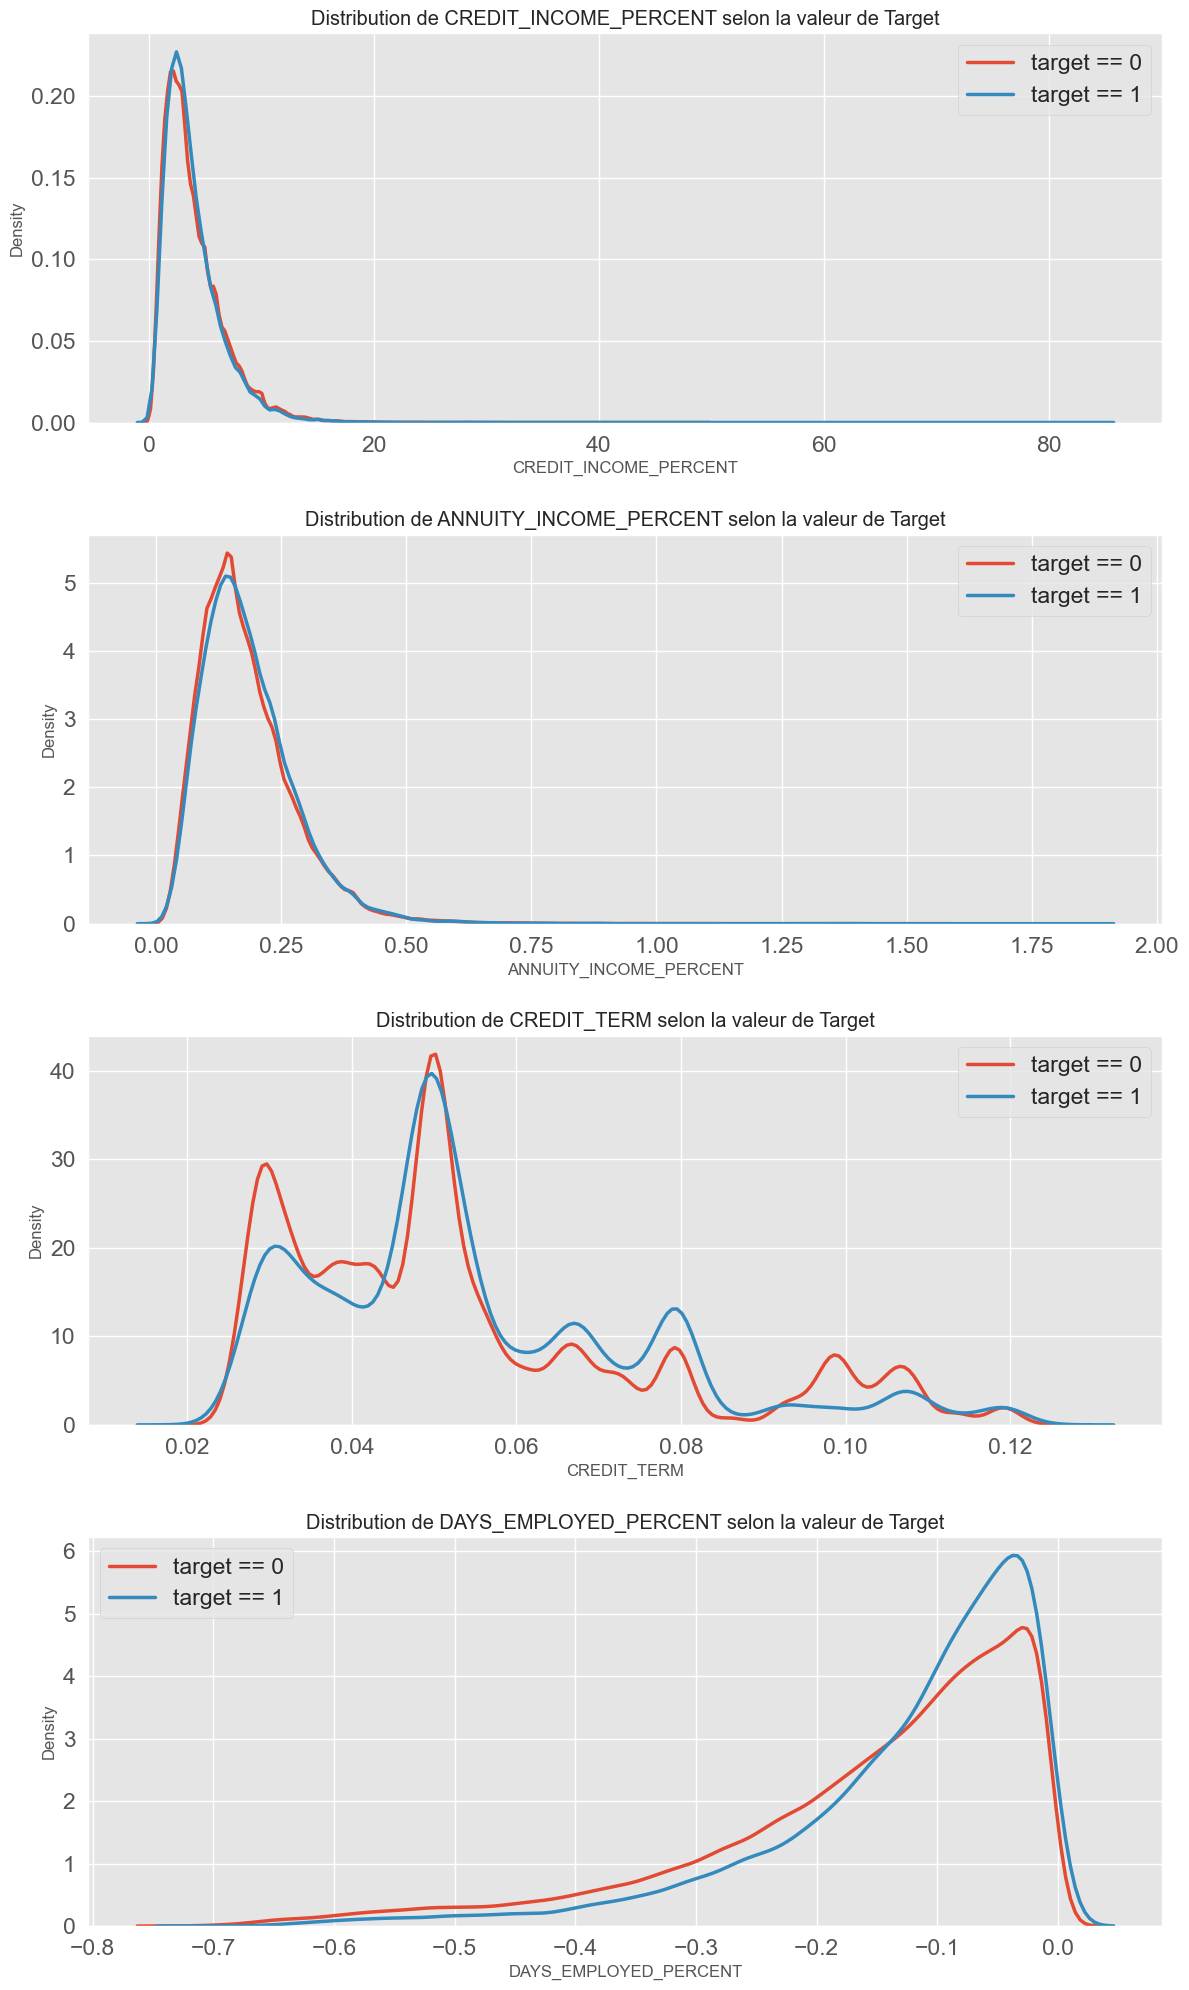

In [63]:
plt.figure(figsize = (12, 20))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # Subplot pour chaque source
    plt.subplot(4, 1, i + 1)
    # Graphique (prêts remboursés)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # Graphique (prêts non-remboursés)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Légende
    plt.title('Distribution de %s selon la valeur de Target' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density')
    plt.legend();
    
plt.tight_layout(h_pad = 2.5)

In [64]:
app_train.drop(columns="SK_ID_CURR", inplace=True)
app_test.drop(columns="SK_ID_CURR", inplace=True)

print("Preprocessing sans features métier")
train, test = preprocesseur(app_train, app_test, "imputer(no features)", "scaler(no features)")
print("Échantillonnage : train = 80% | test = 20%")
X_train, X_test, y_train, y_test = echantillonage(train, app_train["TARGET"])
print("X_train shape :", X_train.shape)
print("X_test shape :", X_test.shape)
print("")


app_train_domain.drop(columns="SK_ID_CURR", inplace=True)
app_test_domain.drop(columns="SK_ID_CURR", inplace=True)

print("Preprocessing avec features métier")
train_domain, test_domain = preprocesseur(app_train_domain, app_test_domain, "imputer", "scaler")
print("Échantillonnage : train = 80% | test = 20%")
X_train_domain, X_test_domain, y_train_domain, y_test_domain = echantillonage(train_domain, app_train["TARGET"])
print("X_train shape :", X_train_domain.shape)
print("X_test shape :", X_test_domain.shape)


Preprocessing sans features métier
Échantillonnage : train = 80% | test = 20%
X_train shape : (246008, 239)
X_test shape : (61503, 239)

Preprocessing avec features métier
Échantillonnage : train = 80% | test = 20%
X_train shape : (246008, 243)
X_test shape : (61503, 243)


# Modélisation 1 - Logistic Regression

## Hypothèse 1 : Pas de feature engineering

In [65]:
# On crée le dataframe de résultats
df_results_base = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# On lance les prédictions
log_reg_pred = log_reg(X_train, y_train, y_test, X_test)

# On enregistre les résultats
df_results_base = save_results(df_results_base, log_reg_pred, "y_pred_lr", y_test)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
df_results_base["y_pred_lr_bin"] = transform_treshold(df_results_base["y_pred_lr"], 0.5)

display(df_results_base.head())
print(df_results_base.shape)

Accuracy: 92.11%


,y_true,y_pred_lr,y_pred_lr_bin
42962,1,0.093096,0
227307,0,0.063556,0
290035,0,0.067366,0
239833,0,0.105164,0
76427,0,0.099360,0


(61503, 3)


## Hypothèse 2 : avec les features métier

In [66]:
# On crée le dataframe de résultats
df_results_base_domain = pd.DataFrame(y_test_domain.values, columns=["y_true"], index=y_test_domain.index)

# On lance les prédictions
log_reg_pred = log_reg(X_train_domain, y_train_domain, y_test_domain, X_test_domain)

# On enregistre les résultats
df_results_base_domain = save_results(df_results_base_domain, log_reg_pred, "y_pred_lr_domain", y_test_domain)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
df_results_base_domain["y_pred_lr_domain_bin"] = transform_treshold(df_results_base_domain["y_pred_lr_domain"], 0.5)

display(df_results_base_domain.head())
print(df_results_base_domain.shape)

Accuracy: 92.11%


,y_true,y_pred_lr_domain,y_pred_lr_domain_bin
42962,1,0.093490,0
227307,0,0.063669,0
290035,0,0.066947,0
239833,0,0.104526,0
76427,0,0.098586,0


(61503, 3)


## Matrice de confusion

Confusion matrix:
 [[56648     0]
 [ 4855     0]]


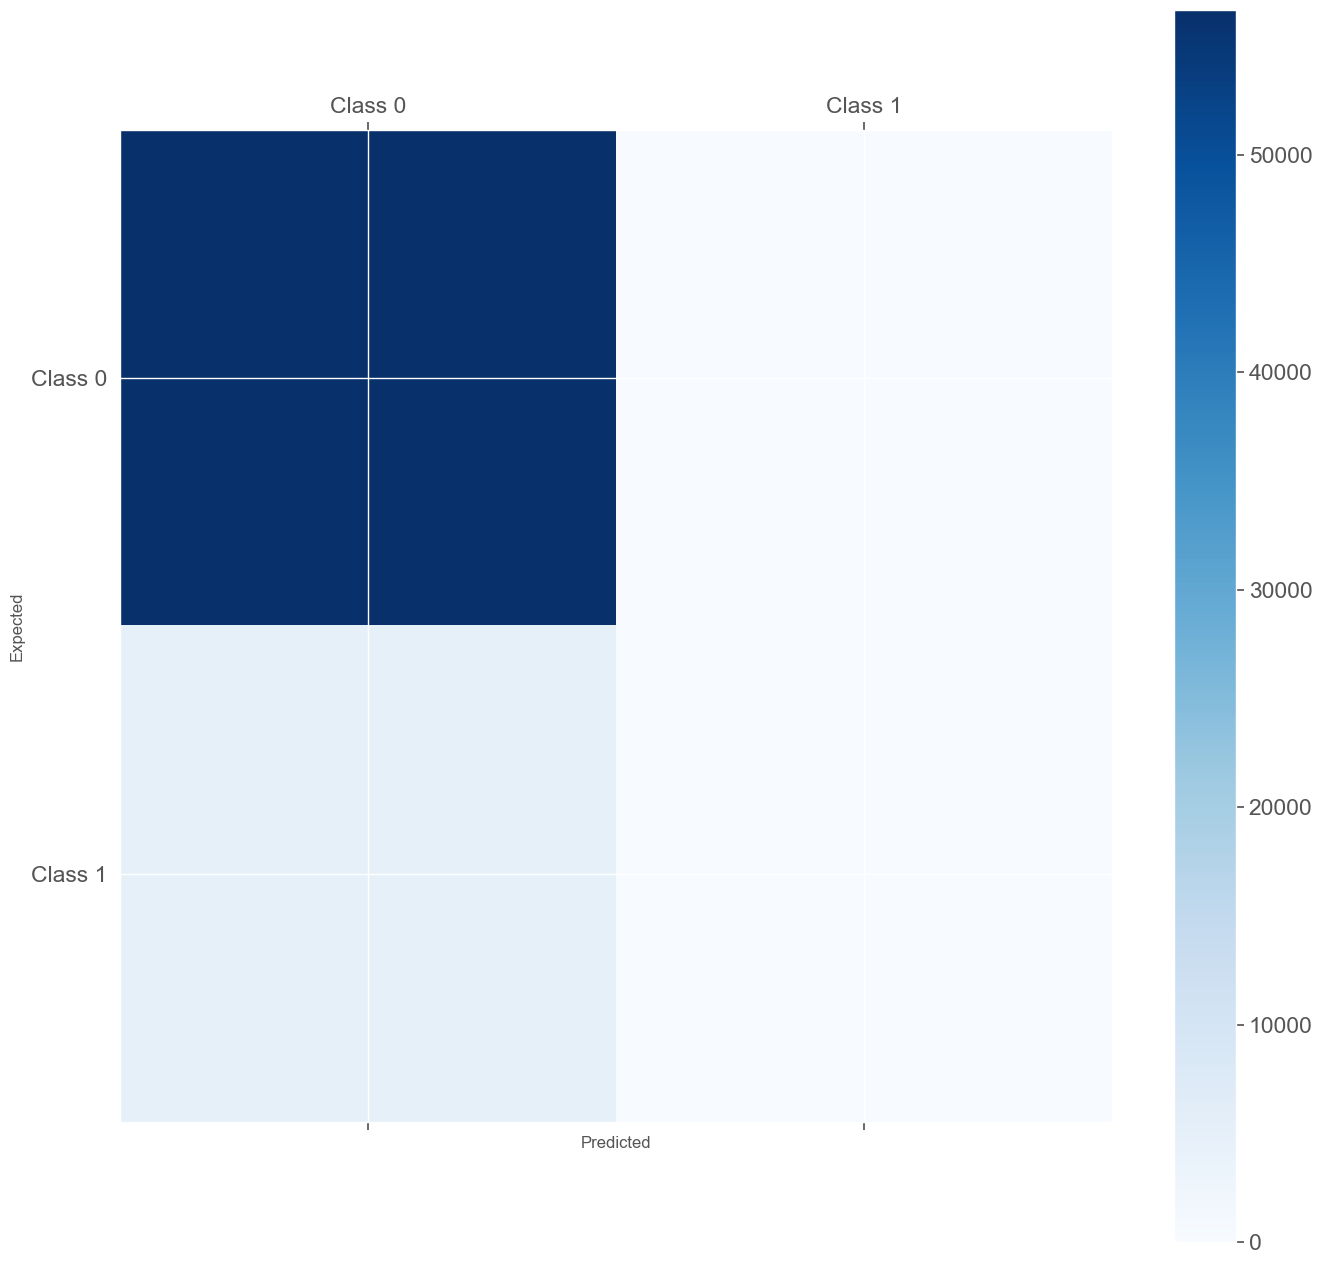

Confusion matrix:
 [[56648     0]
 [ 4855     0]]


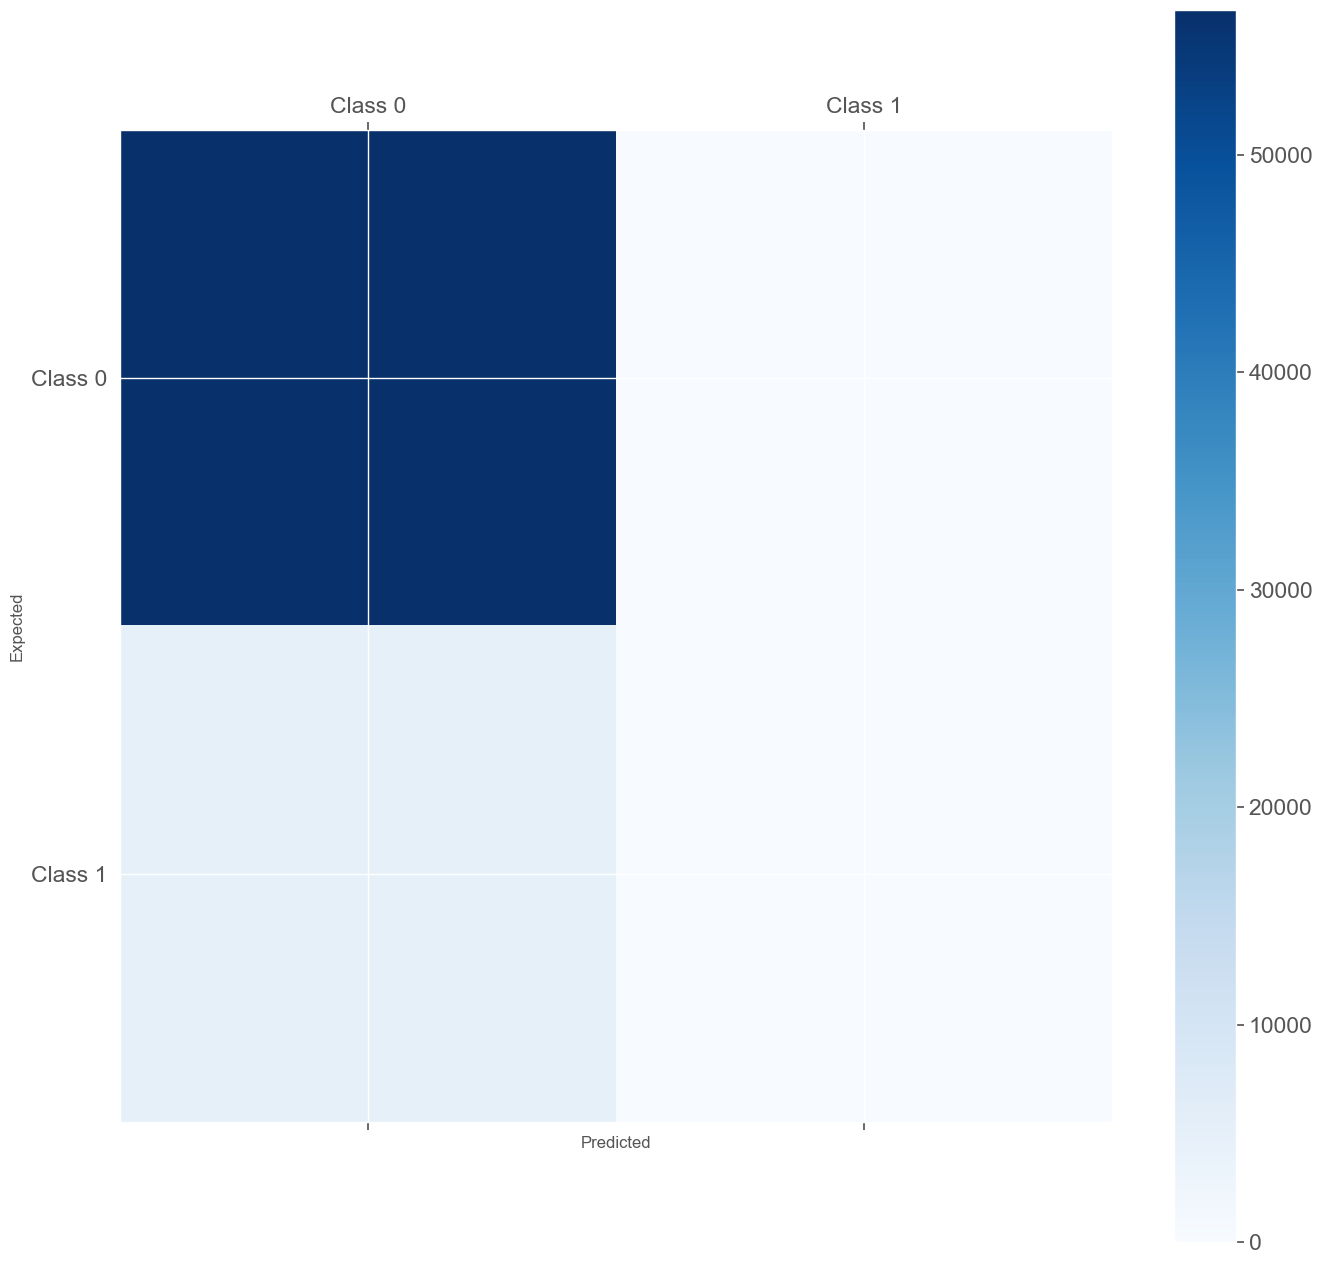

In [67]:
aff_confusion_matrix(df_results_base["y_true"], df_results_base["y_pred_lr_bin"])

aff_confusion_matrix(df_results_base_domain["y_true"], df_results_base_domain["y_pred_lr_domain_bin"])

In [68]:
df_metrics_base = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_score"], index=["sans_feat_eng", "domain_feat"])

df_metrics_base["Accuracy"][0] = round(accuracy_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Precision"][0] = round(precision_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Recall"][0] = round(recall_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["F1_score"][0] = round(f1_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)

df_metrics_base["Accuracy"][1] = round(accuracy_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["Precision"][1] = round(precision_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["Recall"][1] = round(recall_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["F1_score"][1] = round(f1_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)

df_metrics_base

,Accuracy,Precision,Recall,F1_score
sans_feat_eng,0.92,0.0,0.0,0.0
domain_feat,0.92,0.0,0.0,0.0


# Modélisation 2 - avec resampling

In [69]:
print("Rappel du deséquilibre des classes")

percent0 = (y_train.value_counts()[0] / y_train.shape) * 100
percent1 = (y_train.value_counts()[1] / y_train.shape) * 100

print("Nombre d'individus pour la classe 0 :", y_train.value_counts()[0], ". Soit", percent0, "% de la population.")
print("Nombre d'individus pour la classe 1 :", y_train.value_counts()[1], ". Soit", percent1, "% de la population.")

Rappel du deséquilibre des classes
Nombre d'individus pour la classe 0 : 226038 . Soit [91.88237781] % de la population.
Nombre d'individus pour la classe 1 : 19970 . Soit [8.11762219] % de la population.


Class 0: 226038
Class 1: 19970
Proportion: 11.32 : 1


([<matplotlib.patches.Wedge at 0x22339035d30>,
 [Text(-0.2774940275746891, -1.0644233484194048, 'Classe 0'),
  Text(0.3027207573542064, 1.1611891073666234, 'Classe 1')],
 [Text(-0.1513603786771031, -0.5805945536833117, '91.9%'),
  Text(0.1765871084566204, 0.6773603126305303, '8.1%')])

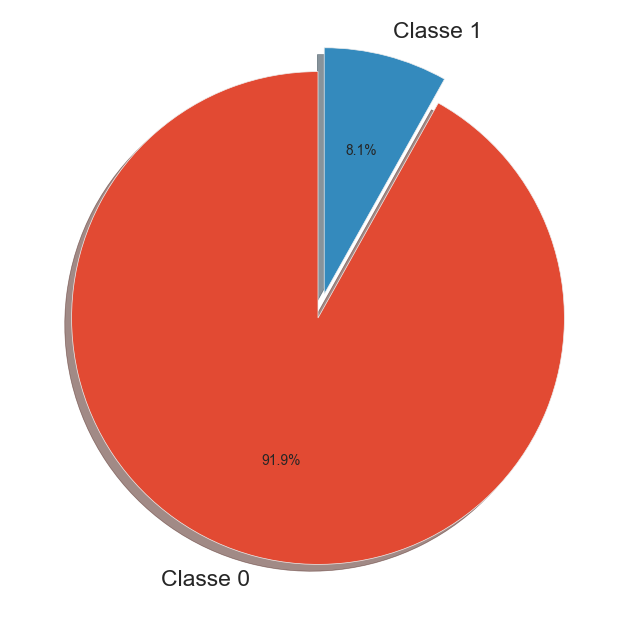

In [70]:
target_count = y_train.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1], labels=["Classe 0", "Classe 1"], autopct='%1.1f%%',
        shadow=True, startangle=90)

## Hypothèse 1 : Pas de feature engineering

In [71]:
%%time

print("Preprocessing")
train, test = preprocesseur(app_train, app_test, "imputer(no features)", "scaler(no features)")

print("Resampling")
smt = RandomUnderSampler()
X_smt, y_smt = smt.fit_resample(train, app_train["TARGET"])

print('Original dataset shape %s' % Counter(app_train["TARGET"]))
print('Resampled dataset shape %s' % Counter(y_smt))

Preprocessing
Resampling
Original dataset shape Counter({0: 282686, 1: 24825})
Resampled dataset shape Counter({0: 24825, 1: 24825})
CPU times: total: 7.05 s
Wall time: 7.18 s


## Hypothèse 2 : Avec les features métier


In [72]:
%%time

print("Preprocessing")
train_domain, test_domain = preprocesseur(app_train_domain, app_test_domain, "imputer", "scaler")

print("Resampling")
X_smt_domain, y_smt_domain = smt.fit_resample(train_domain, app_train["TARGET"])

print('Original dataset shape %s' % Counter(app_train["TARGET"]))
print('Resampled dataset shape %s' % Counter(y_smt_domain))

Preprocessing
Resampling
Original dataset shape Counter({0: 282686, 1: 24825})
Resampled dataset shape Counter({0: 24825, 1: 24825})
CPU times: total: 7.44 s
Wall time: 7.49 s


Class 0: 24825
Class 1: 24825
Proportion: 1.0 : 1


([<matplotlib.patches.Wedge at 0x2233856c6d0>,
 [Text(-1.1, 1.3471114790620887e-16, 'Classe 0'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'Classe 1')],
 [Text(-0.6, 7.347880794884119e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

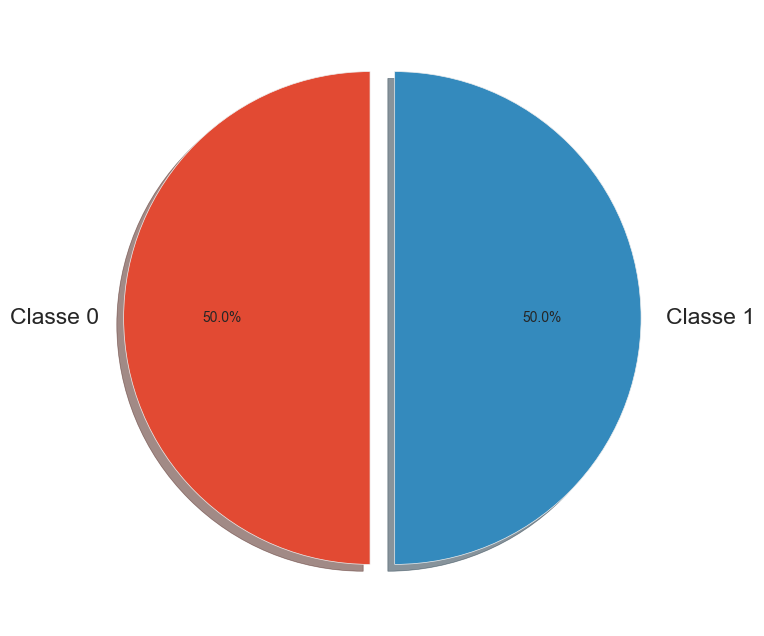

In [73]:
target_count = y_smt.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1], labels=["Classe 0", "Classe 1"], autopct='%1.1f%%',
        shadow=True, startangle=90)

## Analyse de la baseline après rééquilibrage


In [74]:
# On crée le dataframe de résultats
df_results_base = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# On lance les prédictions
log_reg_pred = log_reg(X_smt, y_smt, y_test, X_test)

# On enregistre les résultats
df_results_base = save_results(df_results_base, log_reg_pred, "y_pred_lr", y_test)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
df_results_base["y_pred_lr_bin"] = transform_treshold(df_results_base["y_pred_lr"], 0.5)

display(df_results_base.head())
print(df_results_base.shape)

Accuracy: 60.88%


,y_true,y_pred_lr,y_pred_lr_bin
42962,1,0.519644,1
227307,0,0.438515,0
290035,0,0.447686,0
239833,0,0.556807,1
76427,0,0.527616,1


(61503, 3)


In [75]:
# On crée le dataframe de résultats
df_results_base_domain = pd.DataFrame(y_test_domain.values, columns=["y_true"], index=y_test_domain.index)

# On lance les prédictions
log_reg_pred = log_reg(X_smt_domain, y_smt_domain, y_test_domain, X_test_domain)

# On enregistre les résultats
df_results_base_domain = save_results(df_results_base_domain, log_reg_pred, "y_pred_lr_domain", y_test_domain)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
df_results_base_domain["y_pred_lr_domain_bin"] = transform_treshold(df_results_base_domain["y_pred_lr_domain"], 0.5)

display(df_results_base_domain.head())
print(df_results_base_domain.shape)

Accuracy: 61.09%


,y_true,y_pred_lr_domain,y_pred_lr_domain_bin
42962,1,0.522247,1
227307,0,0.440493,0
290035,0,0.448230,0
239833,0,0.558214,1
76427,0,0.531898,1


(61503, 3)


Confusion matrix:
 [[34320 22328]
 [ 1729  3126]]


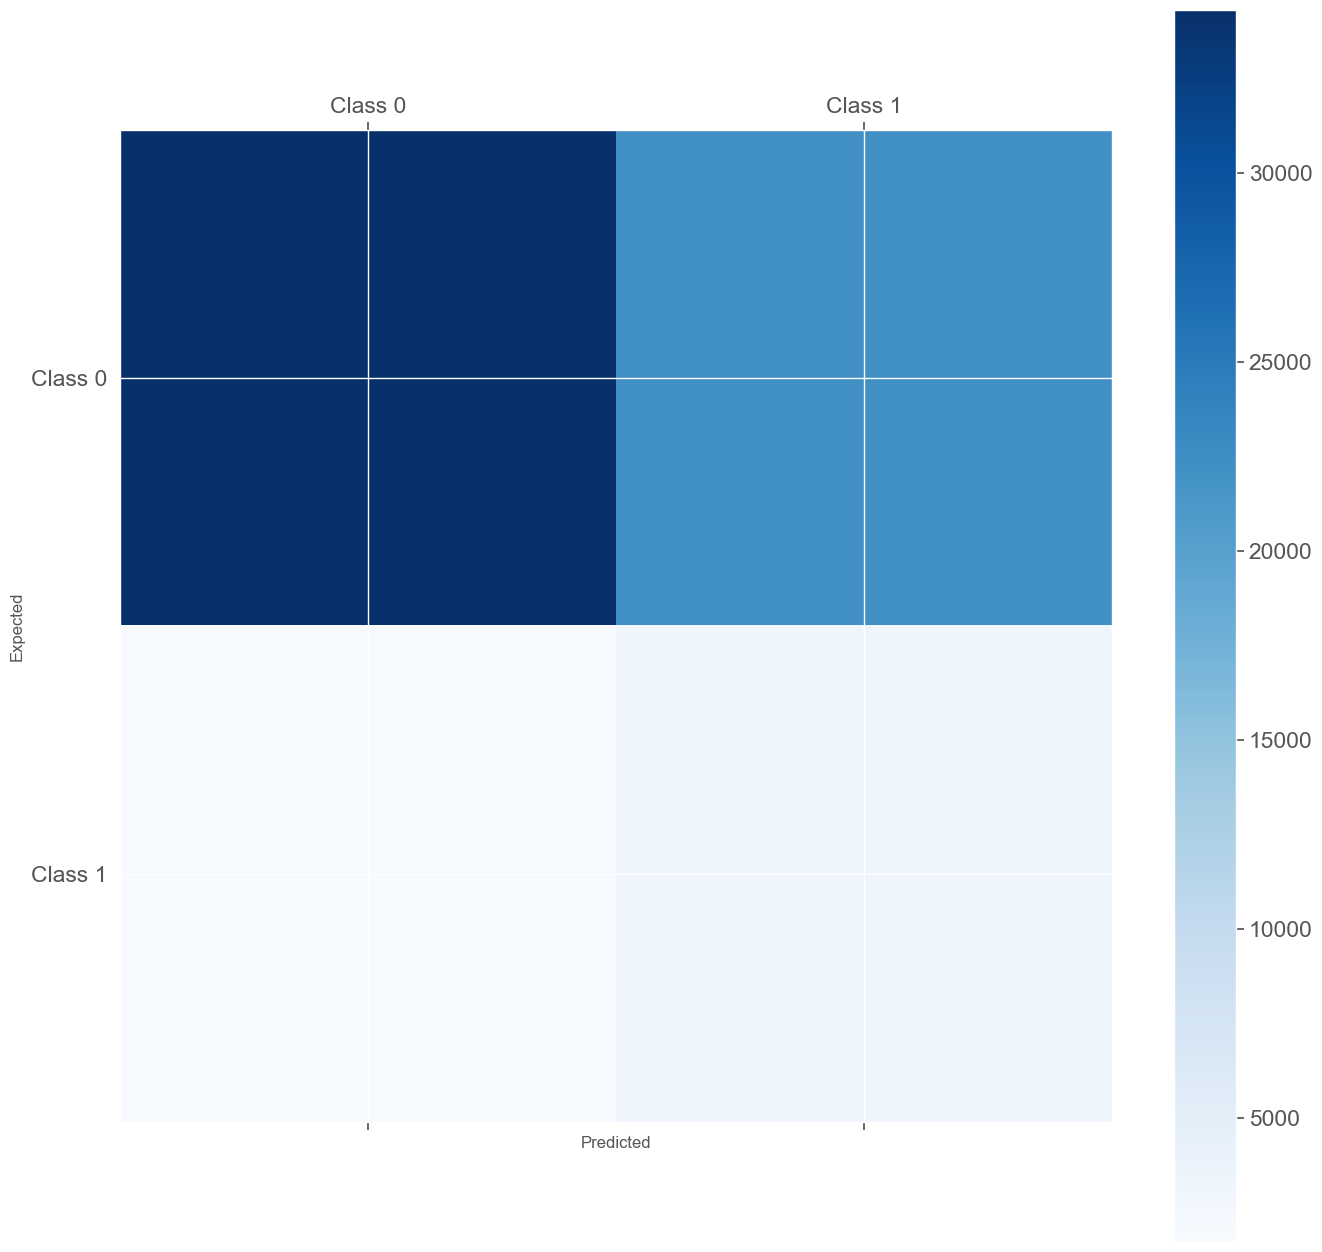

Confusion matrix:
 [[34443 22205]
 [ 1727  3128]]


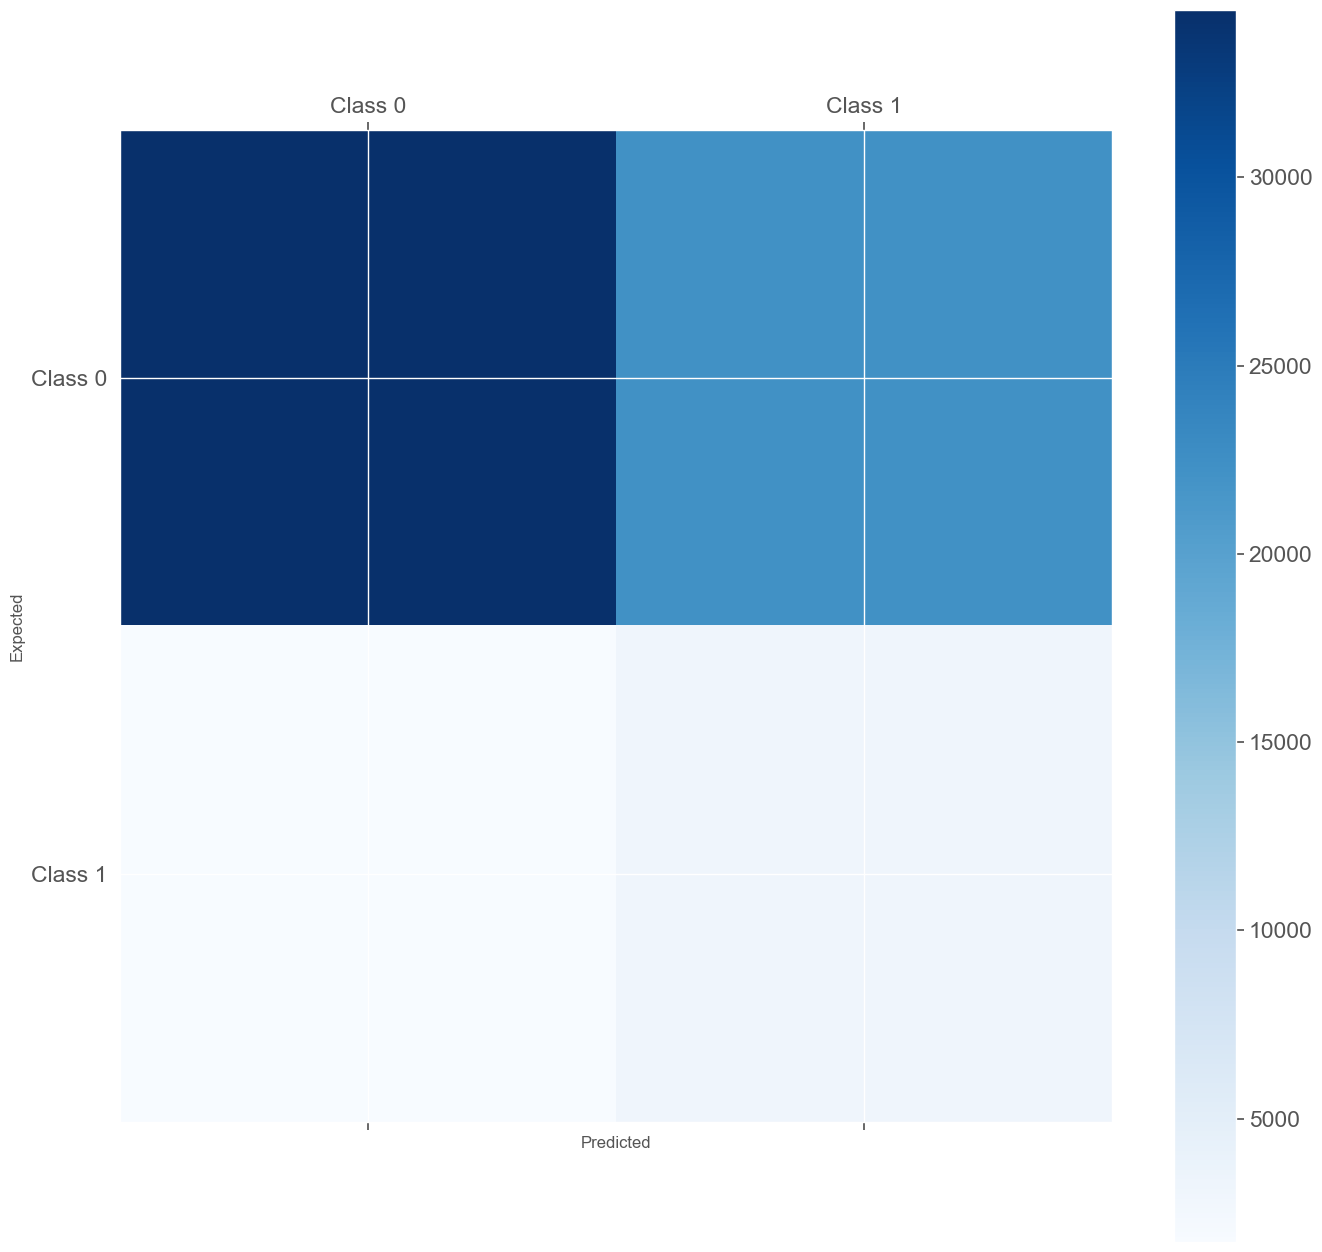

In [76]:
aff_confusion_matrix(df_results_base["y_true"], df_results_base["y_pred_lr_bin"])

aff_confusion_matrix(df_results_base_domain["y_true"], df_results_base_domain["y_pred_lr_domain_bin"])

In [77]:
df_metrics_base = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_score"], index=["sans_feat_eng", "domain_feat"])

df_metrics_base["Accuracy"][0] = round(accuracy_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Precision"][0] = round(precision_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Recall"][0] = round(recall_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["F1_score"][0] = round(f1_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)


df_metrics_base["Accuracy"][1] = round(accuracy_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["Precision"][1] = round(precision_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["Recall"][1] = round(recall_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["F1_score"][1] = round(f1_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)

df_metrics_base

,Accuracy,Precision,Recall,F1_score
sans_feat_eng,0.61,0.12,0.64,0.21
domain_feat,0.61,0.12,0.64,0.21


## Test de différents modèles

On va tester 3 différents modèles : Régression logistique, RandomForestClassifier et XGBoost

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [79]:
df_results = pd.DataFrame(y_test_domain.values, columns=["y_true"], index=y_test_domain.index)

## Régression logistique

In [80]:
%%time

# Création du modèle avec les paramètres spécifiés
clf_lr = LogisticRegression(C=10)

# Entraînement sur le training data
clf_lr.fit(X_smt_domain, y_smt_domain)

# Prédictions
# On choisit uniquement la deuxième colonne
lr_pred_smoted = clf_lr.predict_proba(X_test_domain)[:, 1]

# Dataframe de résultats
df_results["y_pred_lr_smoted"] = lr_pred_smoted

df_results.head()

CPU times: total: 6.05 s
Wall time: 1.08 s


,y_true,y_pred_lr_smoted
42962,1,0.800383
227307,0,0.270396
290035,0,0.471226
239833,0,0.376313
76427,0,0.829419


Une fois que les probabilités de chaque ligne ont été ajoutées au tableau, nous allons les transformer en binaire avec la fonction treshold.

Nous allons paramétrer le treshold sur 0.5.

In [81]:
df_results["y_pred_lr_smoted_bin"] = transform_treshold(df_results["y_pred_lr_smoted"], 0.5)

df_results.head()

,y_true,y_pred_lr_smoted,y_pred_lr_smoted_bin
42962,1,0.800383,1
227307,0,0.270396,0
290035,0,0.471226,0
239833,0,0.376313,0
76427,0,0.829419,1


## Random Forest

In [82]:
%%time

# Création du modèle avec les paramètres spécifiés
clf_rf = RandomForestClassifier(n_estimators=1000,
                                max_depth=10
                               )

# Entraînement sur le training data
clf_rf.fit(X_smt_domain, y_smt_domain)

# Prédictions
# On choisit uniquement la deuxième colonne
rf_pred_smoted = clf_rf.predict_proba(X_test_domain)[:, 1]

# Dataframe de résultats
df_results["y_pred_rf_smoted"] = rf_pred_smoted

df_results.head()

CPU times: total: 1min 27s
Wall time: 1min 27s


,y_true,y_pred_lr_smoted,y_pred_lr_smoted_bin,y_pred_rf_smoted
42962,1,0.800383,1,0.651611
227307,0,0.270396,0,0.271867
290035,0,0.471226,0,0.468153
239833,0,0.376313,0,0.420526
76427,0,0.829419,1,0.616773


In [83]:
df_results["y_pred_rf_smoted_bin"] = transform_treshold(df_results["y_pred_rf_smoted"], 0.5)

df_results.head()

,y_true,y_pred_lr_smoted,y_pred_lr_smoted_bin,y_pred_rf_smoted,y_pred_rf_smoted_bin
42962,1,0.800383,1,0.651611,1
227307,0,0.270396,0,0.271867,0
290035,0,0.471226,0,0.468153,0
239833,0,0.376313,0,0.420526,0
76427,0,0.829419,1,0.616773,1


## XGBoost

In [84]:
clf_xgb = xgb.XGBClassifier(objective="binary:logistic",
                            random_state=0)

clf_xgb.fit(X_smt_domain, y_smt_domain)

# Prédictions
# On choisit uniquement la deuxième colonne
xgb_pred_smoted = clf_xgb.predict_proba(X_test_domain)[:, 1]

# Dataframe de résultats
df_results["y_pred_xgb_smoted"] = xgb_pred_smoted

df_results.head()

,y_true,y_pred_lr_smoted,y_pred_lr_smoted_bin,y_pred_rf_smoted,y_pred_rf_smoted_bin,y_pred_xgb_smoted
42962,1,0.800383,1,0.651611,1,0.875480
227307,0,0.270396,0,0.271867,0,0.310275
290035,0,0.471226,0,0.468153,0,0.617020
239833,0,0.376313,0,0.420526,0,0.247797
76427,0,0.829419,1,0.616773,1,0.857113


In [85]:
df_results["y_pred_xgb_smoted_bin"] = transform_treshold(df_results["y_pred_xgb_smoted"], 0.5)

df_results.head()

,y_true,y_pred_lr_smoted,y_pred_lr_smoted_bin,y_pred_rf_smoted,y_pred_rf_smoted_bin,y_pred_xgb_smoted,y_pred_xgb_smoted_bin
42962,1,0.800383,1,0.651611,1,0.875480,1
227307,0,0.270396,0,0.271867,0,0.310275,0
290035,0,0.471226,0,0.468153,0,0.617020,1
239833,0,0.376313,0,0.420526,0,0.247797,0
76427,0,0.829419,1,0.616773,1,0.857113,1


## Analyse des résultats

## Matrice de confusion

Analysons la matrice de confusion de chaque modèle pour visualiser le nombre de TN, FN, TP, FN.

Matrice confusion régression logistique
Confusion matrix:
 [[38793 17855]
 [ 1537  3318]]


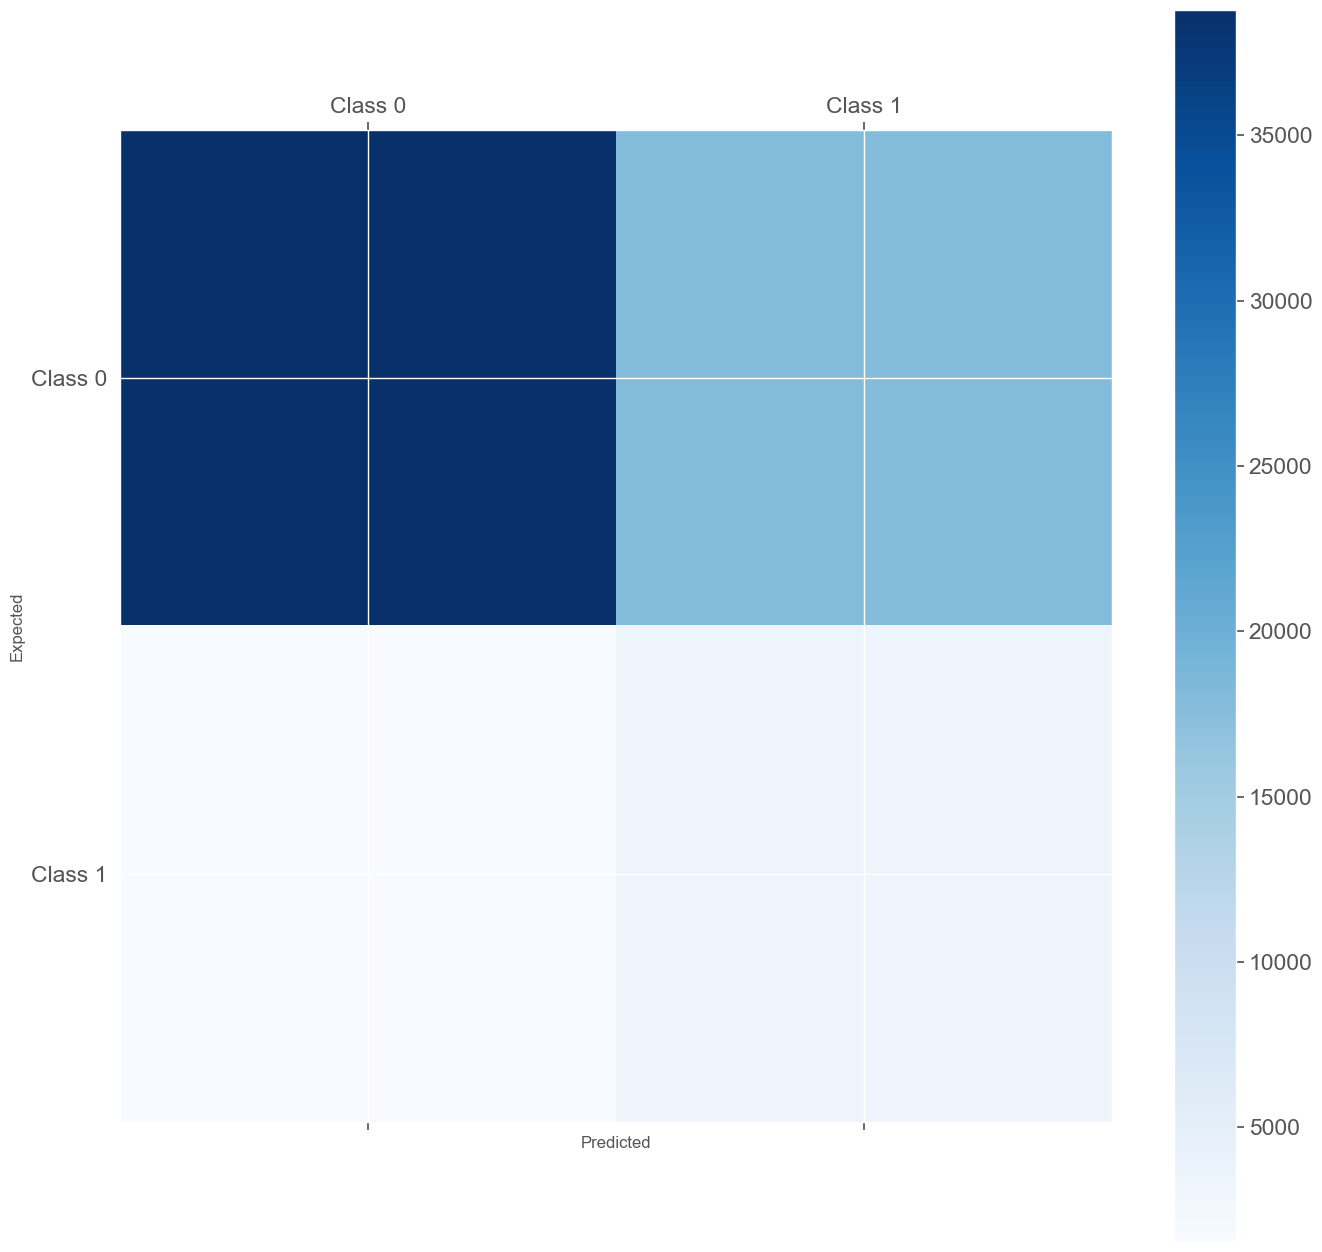

Matrice confusion random forest
Confusion matrix:
 [[38517 18131]
 [ 1192  3663]]


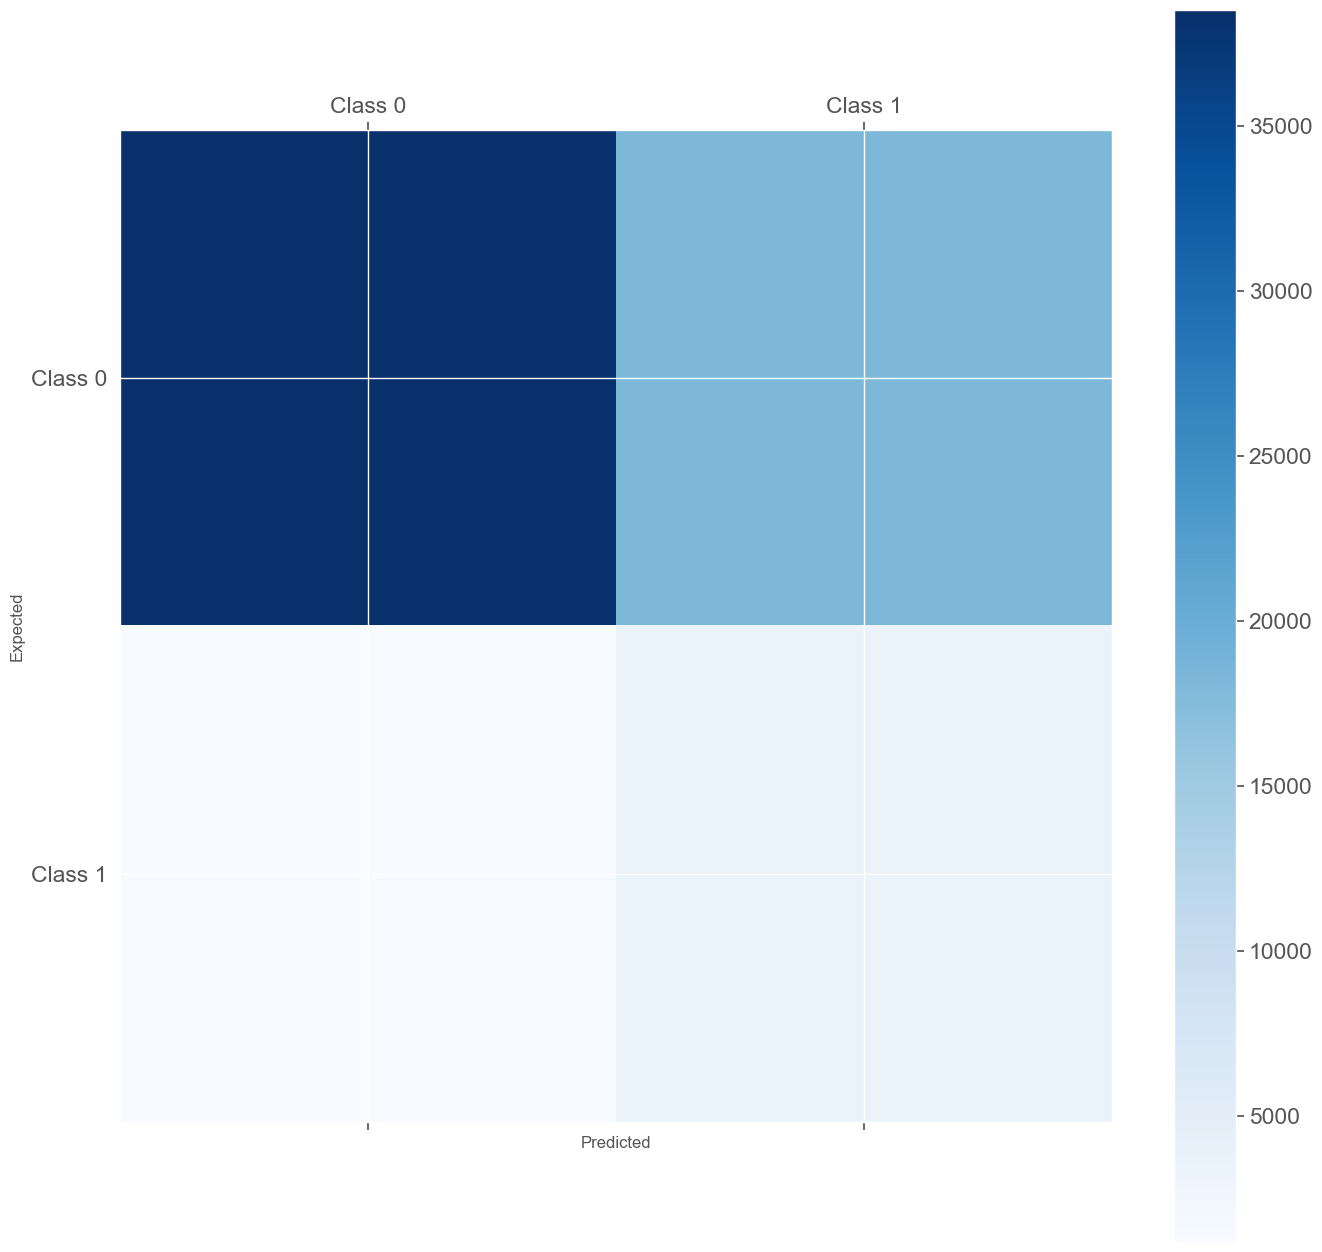

Matrice confusion XGBoost
Confusion matrix:
 [[39608 17040]
 [  916  3939]]


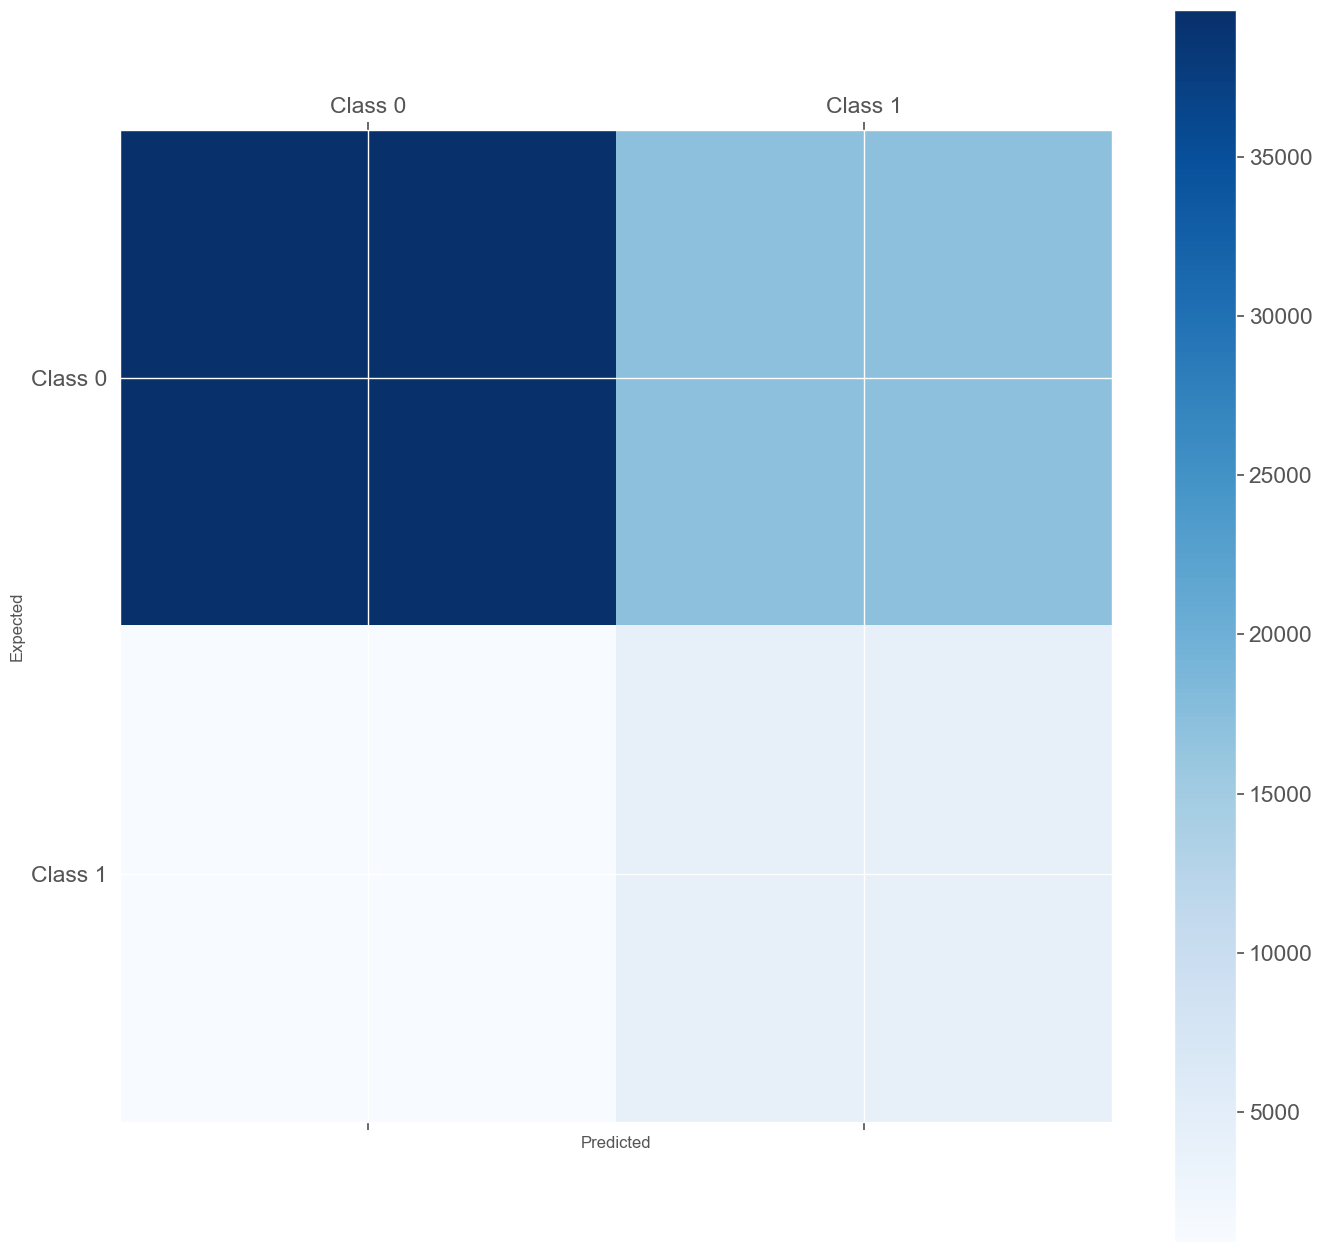

In [86]:
print("Matrice confusion régression logistique")
aff_confusion_matrix(df_results["y_true"], df_results["y_pred_lr_smoted_bin"])

print("Matrice confusion random forest")
aff_confusion_matrix(df_results["y_true"], df_results["y_pred_rf_smoted_bin"])

print("Matrice confusion XGBoost")
aff_confusion_matrix(df_results["y_true"], df_results["y_pred_xgb_smoted_bin"])

## Accuracy, Precision, Recall, F1 Score

Nous allons mesurer différentes métriques pour bien comprendre les classifieurs :

    L'accuracy : Nous avons vu ici que l'accuracy ne signifait pas grand chose.
    La précision : Ce coefficient détermine que, quand le classifieur déclare que la prédiction est un 1, il a raison à X%.
    Le rappel : Ce coefficient détermine le pourcentage de détection des 1 du classifieur.
    Le F1-score : Ce coefficient est une moyenne de la précision et du rappel, mais, de part sa formule il donne plus de poids aux faibles valeurs.

In [87]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

nb_models = 3

df_metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_score"], index=["Logistic regression", "Random Forest", "XGBoost"])

# j=2 représente la 2ème colonne du dataframe df_results
# on cible les colonnes de valeurs prédites avec cette variable
j = 2

for i in np.arange(0, nb_models):

    df_metrics["Accuracy"][i] = round(accuracy_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["Precision"][i] = round(precision_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["Recall"][i] = round(recall_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["F1_score"][i] = round(f1_score(df_results["y_true"], df_results.iloc[:, j]), 2)

    j += 2

df_metrics

,Accuracy,Precision,Recall,F1_score
Logistic regression,0.68,0.16,0.68,0.25
Random Forest,0.69,0.17,0.75,0.27
XGBoost,0.71,0.19,0.81,0.3


## Courbe Receiver Operating Characteristic (ROC) et Area Under the Curve (AUC)

La courbe ROC est un outil communément utilisé avec les classifieurs binaires. Elle croise le taux de TP avec le taux de FP. Le taux de FP est le pourcentage d'observations négatives qui sont incorrectement classées comme positives. Il est égal à 1 moins le taux de TN, qui est le pourcentage d'observations négatives qui sont correctement classées comme négatives. Le taux de FN est aussi appelé spécificité. Par conséquent la courbe ROC croise sensibilité (ou rappel) et 1-spécificité.

La meilleure courbe ROC, est celle qui passe le plus dans le coin supérieur gauche du graphique.

Le score AUC est une façon de comparer des classificateurs. Un classificateur parfait aurait une aire sous la courbe ROC égale à 1, tandis qu'un classificateur purement aléatoire aurait une ROC AUC de 0.5.

In [88]:
from sklearn.metrics import roc_curve

fp_lr, tp_lr, treshold_lr = roc_curve(y_test_domain, lr_pred_smoted)
fp_rf, tp_rf, treshold_rf = roc_curve(y_test_domain, rf_pred_smoted)
fp_xgb, tp_xgb, treshold_xgb = roc_curve(y_test_domain, xgb_pred_smoted)

In [89]:
from sklearn.metrics import roc_auc_score

auc_score_lr = roc_auc_score(y_test_domain, lr_pred_smoted)
auc_score_rf = roc_auc_score(y_test_domain, rf_pred_smoted)
auc_score_xgb = roc_auc_score(y_test_domain, xgb_pred_smoted)

lst_auc_score = [("Logistic Regression", auc_score_lr),
                ("Random Forest", auc_score_rf),
                ("XGBoost", auc_score_xgb)]

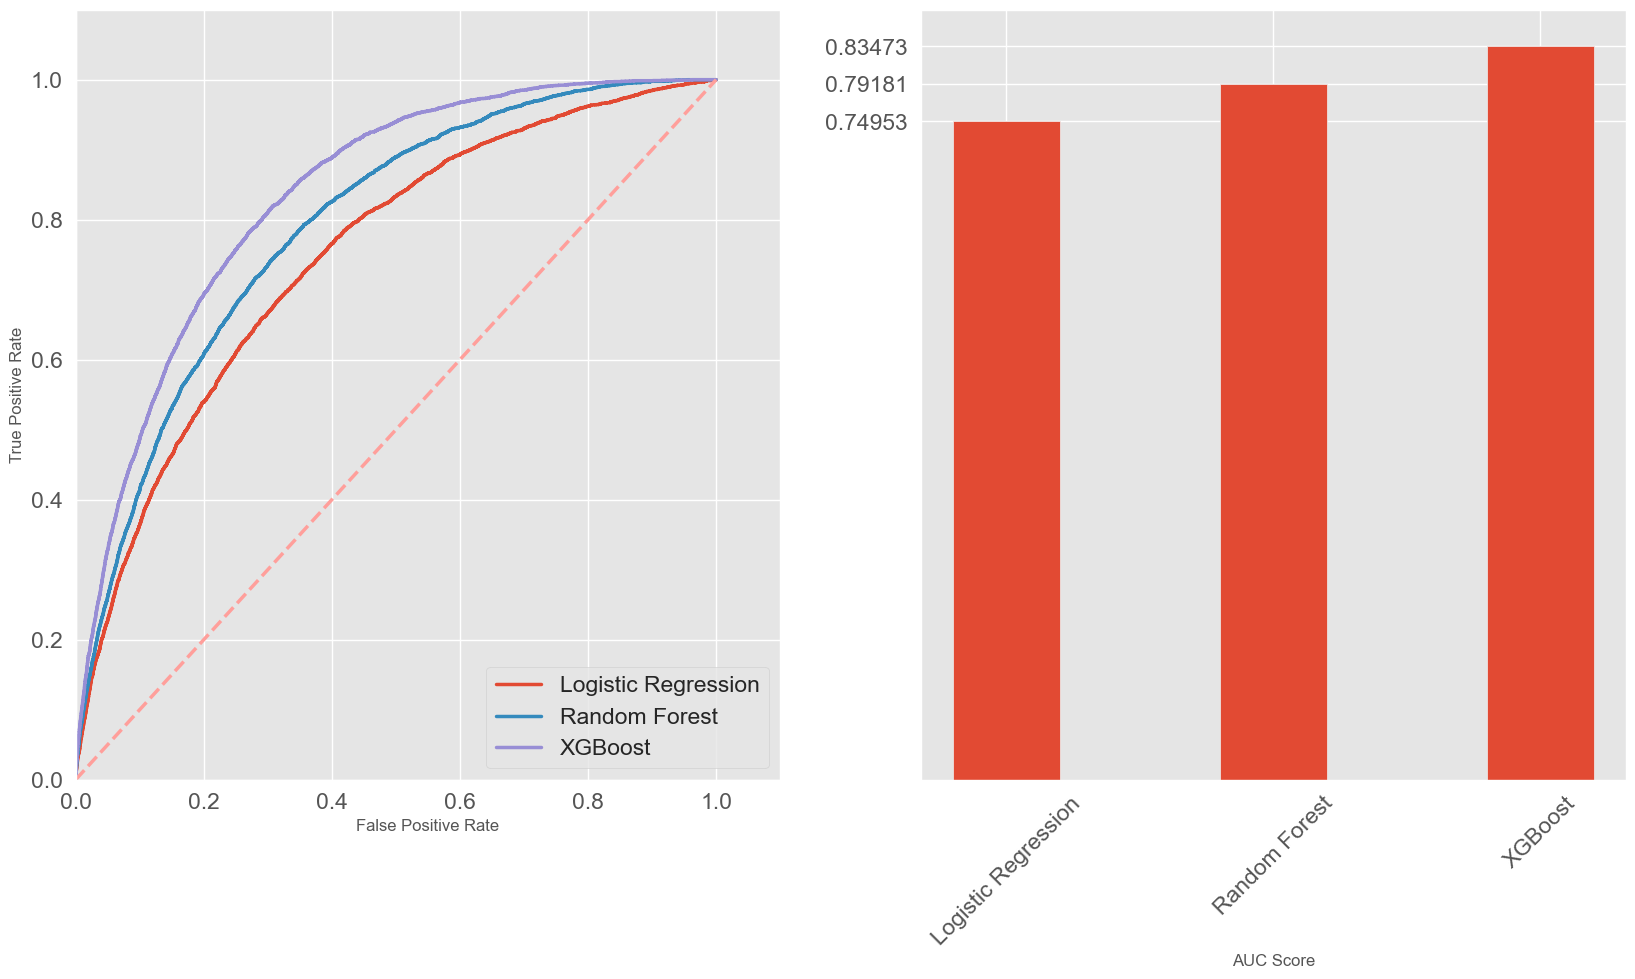

In [90]:
plt.figure(figsize=(20,10))


plt.subplot(1, 2, 1)

plt.plot(fp_lr, tp_lr, label="Logistic Regression")
plt.plot(fp_rf, tp_rf, label="Random Forest")
plt.plot(fp_xgb, tp_xgb, label="XGBoost")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.subplot(1, 2, 2)

plt.style.use('fivethirtyeight')

labels, ys = zip(*lst_auc_score)

xs = np.arange(len(labels))

width = 0.4

plt.bar(xs, ys, width, align='center')

plt.xlabel("AUC Score")
plt.xticks(xs, labels, rotation=45) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys)
plt.show()

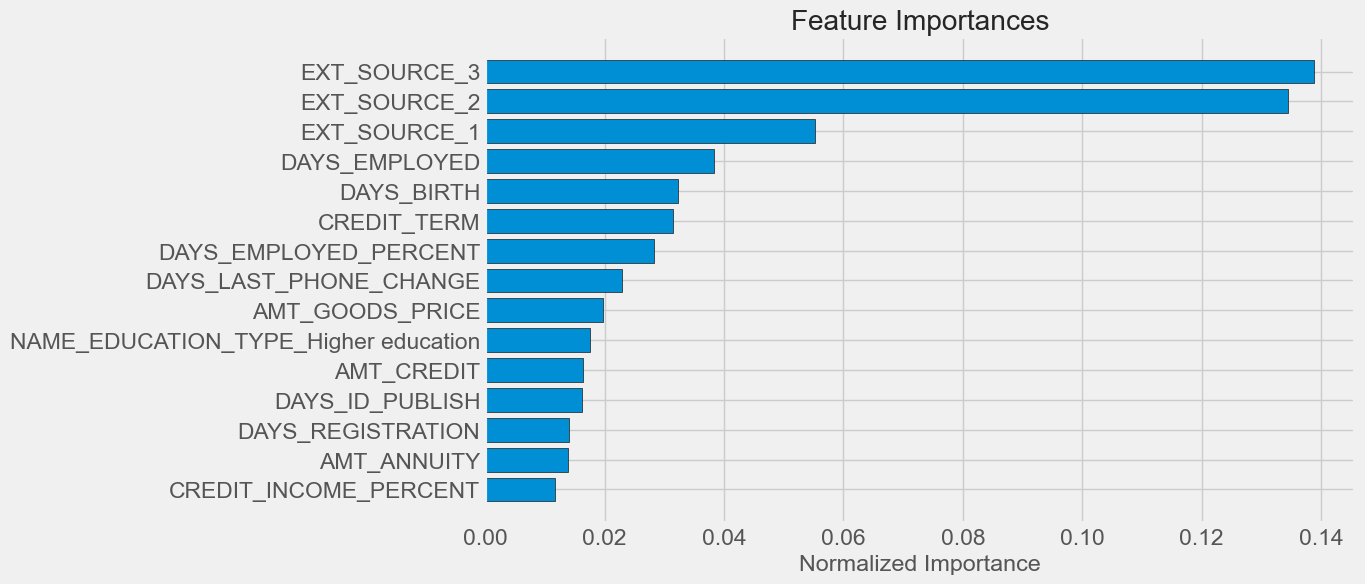

In [91]:
# Dataframe des features importance
feature_importances = pd.DataFrame({'feature': app_test_domain.columns, 'importance': clf_rf.feature_importances_})

fi_sorted = plot_feature_importances(feature_importances)

## Conclusion sur modeling

Le modèle XGBoost semble donner les meilleurs résultats.

On va essayer d'optimiser les paramètres de celui-ci avant de sauvegarder le modèle pour utilisation dans notre API.

In [ ]:
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    eval_metric="auc"
)

In [ ]:
parameters = {
    'max_depth': range(2, 10, 1),
    'n_estimators': range(60, 2000, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'subsample': stats.uniform(0.3, 0.9),
    'colsample_bytree': [0.1, 0.01, 0.05],
    'min_child_weight': range(1, 10, 1)
}

In [ ]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [ ]:
grid_search.fit(X_train_domain, y_train_domain)

In [ ]:
grid_search.best_estimator_

In [92]:
clf_xgb_o = xgb.XGBClassifier(booster='gbtree',
                                colsample_bytree=0.6784538670198459,
                                eval_metric='auc',
                                learning_rate=0.10310087264740633,
                                max_depth=6,
                                min_child_weight=2,
                                n_estimators=1144,
                                objective='binary:logistic',
                                random_state=0,
                                subsample=0.4915549740714592,
                                n_jobs=-1
                                )

clf_xgb_o.fit(X_smt_domain, y_smt_domain)
model_final = clf_xgb_o.fit(X_smt_domain, y_smt_domain)
joblib.dump(model_final, "clf_xgb_o.pkl")

# Prédictions
# On choisit uniquement la deuxième colonne
xgb_o_pred_smoted = clf_xgb_o.predict_proba(X_test_domain)[:, 1]

# Dataframe de résultats
df_results["y_pred_xgb_o_smoted"] = xgb_o_pred_smoted

df_results.head()

,y_true,y_pred_lr_smoted,y_pred_lr_smoted_bin,y_pred_rf_smoted,y_pred_rf_smoted_bin,y_pred_xgb_smoted,y_pred_xgb_smoted_bin,y_pred_xgb_o_smoted
42962,1,0.800383,1,0.651611,1,0.875480,1,0.826978
227307,0,0.270396,0,0.271867,0,0.310275,0,0.371472
290035,0,0.471226,0,0.468153,0,0.617020,1,0.322877
239833,0,0.376313,0,0.420526,0,0.247797,0,0.263779
76427,0,0.829419,1,0.616773,1,0.857113,1,0.974838


In [ ]:
print(model_final.get_booster().feature_names)

In [ ]:
df_results["y_pred_xgb_o_smoted_bin"] = transform_treshold(df_results["y_pred_xgb_o_smoted"], 0.5)

df_results.head()

In [ ]:
nb_models = 4

df_metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_score"], index=["Logistic regression", "Random Forest", "XGBoost","XGBoost_optimisé"])

# j=2 représente la 2ème colonne du dataframe df_results
# on cible les colonnes de valeurs prédites avec cette variable
j = 2

for i in np.arange(0, nb_models):

    df_metrics["Accuracy"][i] = round(accuracy_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["Precision"][i] = round(precision_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["Recall"][i] = round(recall_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["F1_score"][i] = round(f1_score(df_results["y_true"], df_results.iloc[:, j]), 2)

    j += 2

df_metrics

In [ ]:
fp_xgb_o, tp_xgb_o, treshold_xgb_o = roc_curve(y_test_domain, xgb_o_pred_smoted)

In [ ]:
auc_score_xgb_o = roc_auc_score(y_test_domain, xgb_o_pred_smoted)

lst_auc_score = [("Logistic Regression", auc_score_lr),
                ("Random Forest", auc_score_rf),
                ("XGBoost", auc_score_xgb),
                ("XGBoost_optimisé", auc_score_xgb_o)]

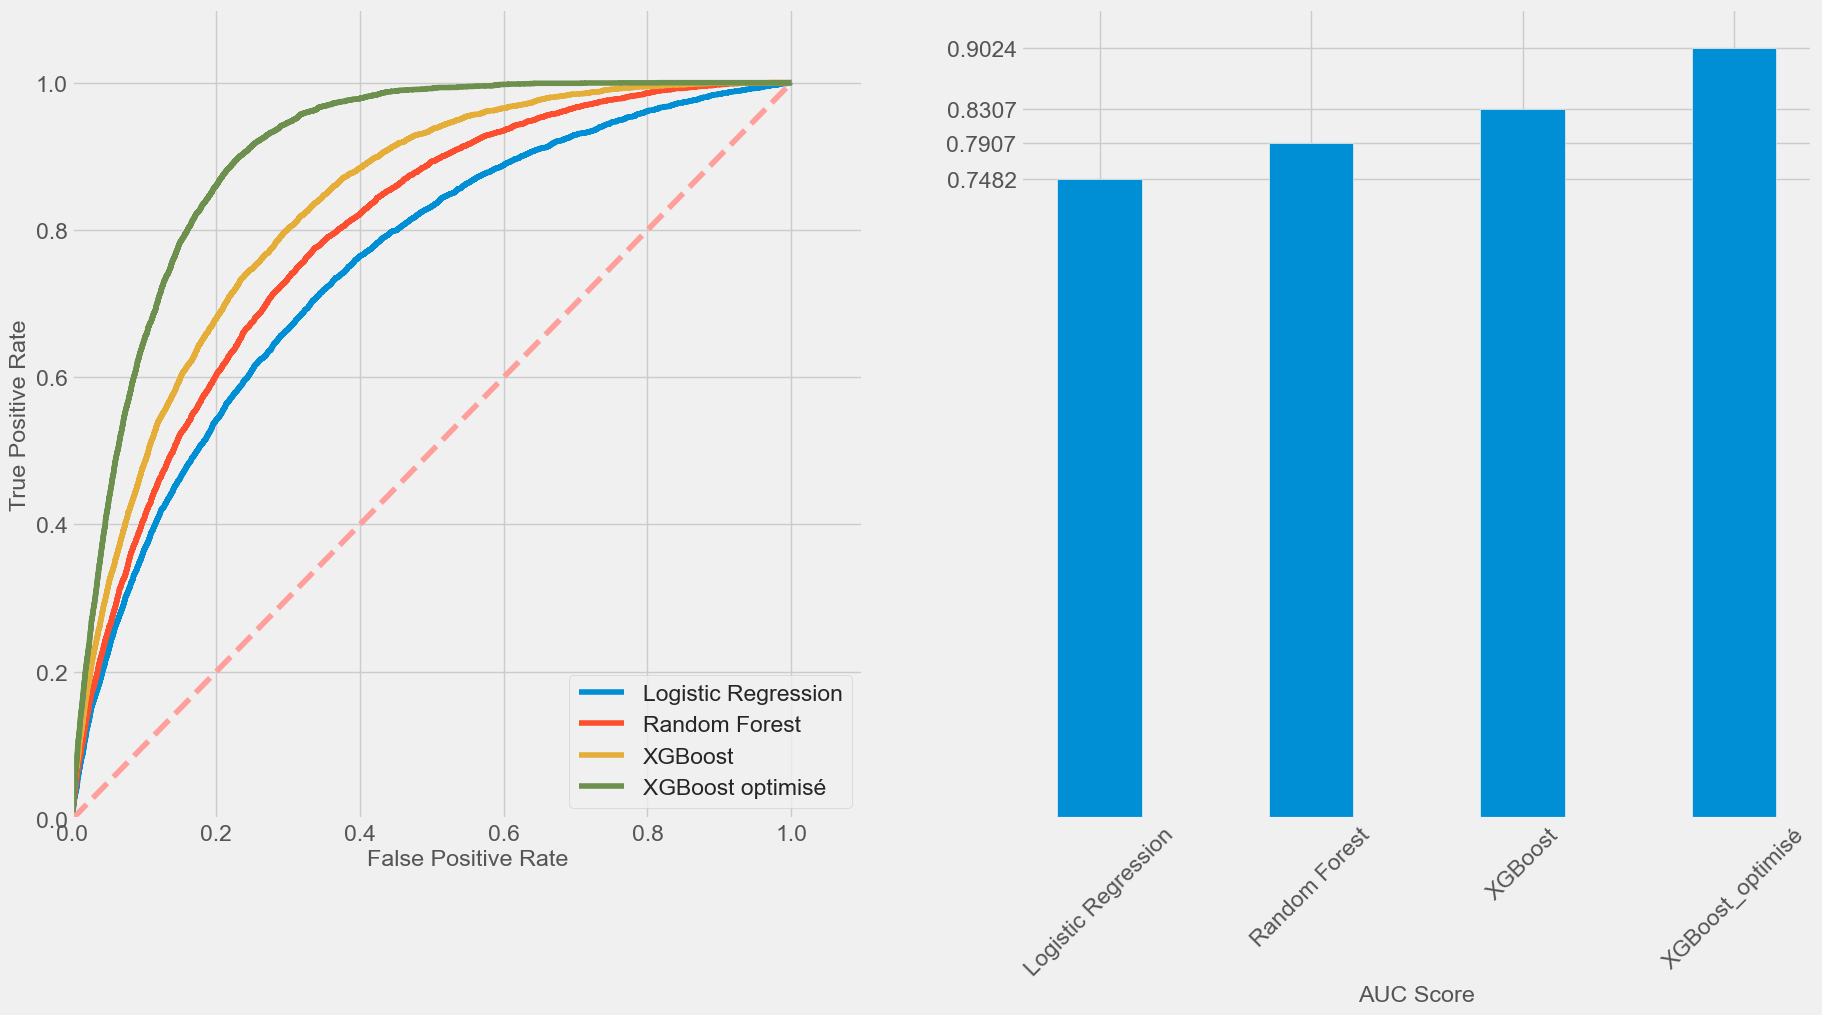

In [97]:
plt.figure(figsize=(20,10))


plt.subplot(1, 2, 1)

plt.plot(fp_lr, tp_lr, label="Logistic Regression")
plt.plot(fp_rf, tp_rf, label="Random Forest")
plt.plot(fp_xgb, tp_xgb, label="XGBoost")
plt.plot(fp_xgb_o, tp_xgb_o, label="XGBoost optimisé")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.subplot(1, 2, 2)

plt.style.use('fivethirtyeight')

labels, ys = zip(*lst_auc_score)

xs = np.arange(len(labels))

width = 0.4

plt.bar(xs, ys, width, align='center')

plt.xlabel("AUC Score")
plt.xticks(xs, labels, rotation=45) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys)
plt.show()

## Sauvegarde du modèle

In [362]:
joblib.dump(clf_xgb_o, "clf_xgb_o.pkl")

['clf_xgb_o.pkl']